In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
from __future__ import print_function

from hyperopt import Trials, STATUS_OK, tpe
from keras.layers.core import Dense, Dropout, Activation
from keras.models import Sequential
from keras.utils import np_utils
from keras.models import load_model
from keras.utils import multi_gpu_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from hyperas import optim
from hyperas.distributions import choice, uniform, conditional
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from talos.metrics.keras_metrics import fmeasure


Using TensorFlow backend.


In [3]:
#Function to read data-----------------------------------------------------------------------
def data_input():
    data = pd.read_csv('conventional_data_unique.csv', index_col = 'CID')
    y = pd.get_dummies(data['consensus_act'])

    X = data.drop(['consensus_act', 'gmin'], axis = 1)
    X.replace([np.inf, -np.inf], np.nan, inplace=True) #replace all infinite values with NaN

    X = X.dropna(axis=1, how='all') #Drop any column that has all NaN
    X.fillna(value = X.mean(axis=0), inplace=True) #Impute mean in place on NaN

    #X.loc[:, X.isnull().any()] See which column still had NaN after prepocessing. gmin was removed
    print('Shape of X before removing low variance features:', X.shape)

    #0.16 =(.8 * (1 - .8)) that is the threshold for features that are constant in 80% of the instances
    feat = VarianceThreshold(threshold=0.16)
    feat.fit_transform(X)
    X = X[X.columns[feat.get_support(indices=True)]] #retain column names

    print('Shape of X after removing low variance features:', X.shape)

    #This represents only ONE EXTERNAL SPLIT ()
    Xtrain, Xtest, y_train, y_test = train_test_split(X, y.values, stratify=y, test_size=0.2)
    Xtrain, Xval, y_train, yval = train_test_split(Xtrain, y_train, stratify=y_train, test_size=0.1)

    sc = StandardScaler().fit(Xtrain)
    X_train = pd.DataFrame(sc.transform(Xtrain), columns = X.columns)
    X_test = pd.DataFrame(sc.transform(Xtest), columns = X.columns)
    X_val = pd.DataFrame(sc.transform(Xval), columns = X.columns)
    return X_train, y_train, X_test, y_test, X_val, yval

In [4]:
#Create the model---------------------------------------------------------------
def create_model(X_train, y_train, X_test, y_test, X_val, yval):
    """
    Model providing function:

    Create Keras model with double curly brackets dropped-in as needed.
    Return value has to be a valid python dictionary with two customary keys:
        - loss: Specify a numeric evaluation metric to be minimized
        - status: Just use STATUS_OK and see hyperopt documentation if not feasible
    The last one is optional, though recommended, namely:
        - model: specify the model just created so that we can later use it again.
    """
    model = Sequential()
    model.add(Dense({{choice([32, 64, 128, 256, 512, 1024])}},
                        activation='relu', input_shape= (2544,)))
    model.add(Dropout({{uniform(0, 1)}}))
    model.add(Dense({{choice([32, 64, 128, 256, 512, 1024])}}))
    model.add(Activation({{choice(['relu', 'sigmoid'])}}))
    model.add(Dropout({{uniform(0, 1)}}))

    # If we choose 'four', add an additional fourth layer
    if conditional({{choice(['three', 'four'])}}) == 'four':
        model.add(Dense({{choice([32, 64, 128, 256, 512, 1024])}}))

        # We can also choose between complete sets of layers

        model.add({{choice([Dropout(0.5), Activation('linear')])}})
        model.add(Activation('relu'))

    model.add(Dense(4))
    model.add(Activation('softmax'))

    #parallel_model = multi_gpu_model(model, gpus=2)
    model.compile(loss='categorical_crossentropy', metrics=[fmeasure],
                  optimizer={{choice(['rmsprop', 'adam', 'sgd'])}})
    
    #early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001)

    model.fit(X_train, y_train,
              batch_size={{choice([8, 16, 32, 64, 128])}},
              epochs=200,
              verbose=2,
              validation_data=(X_val, yval), callbacks=[reduce_lr])

    score, acc = model.evaluate(X_test, y_test, verbose=0)
    print('Validation Accuracy:', acc)
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}


#----------------------------------------------------------------------

best_run, best_model = optim.minimize(model=create_model,
                                      data=data_input,
                                      algo=tpe.suggest,
                                      max_evals=50,
                                      trials=Trials(),
                                     notebook_name='Conv_Hyperas_Notebook2_unique_val')

>>> Imports:
#coding=utf-8

from __future__ import print_function

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

try:
    from keras.layers.core import Dense, Dropout, Activation
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.utils import np_utils
except:
    pass

try:
    from keras.models import load_model
except:
    pass

try:
    from keras.utils import multi_gpu_model
except:
    pass

try:
    from keras.callbacks import EarlyStopping, ReduceLROnPlateau
except:
    pass

try:
    from sklearn.metrics import classification_report, confusion_matrix
except:
    pass

try:
    from sklearn import metrics
except:
    pass

try:
    from hyperas import optim
except:
    pass

try:
    from hyperas.distributions import choice, uniform, conditional
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    from sklearn.model_selection import train_

Epoch 19/200
 - 2s - loss: 0.6204 - fmeasure: 0.7212 - val_loss: 0.6135 - val_fmeasure: 0.6979
Epoch 20/200
 - 2s - loss: 0.6106 - fmeasure: 0.7296 - val_loss: 0.6156 - val_fmeasure: 0.7157
Epoch 21/200
 - 2s - loss: 0.6040 - fmeasure: 0.7373 - val_loss: 0.6119 - val_fmeasure: 0.7259
Epoch 22/200
 - 2s - loss: 0.6044 - fmeasure: 0.7337 - val_loss: 0.6049 - val_fmeasure: 0.7110
Epoch 23/200
 - 2s - loss: 0.6018 - fmeasure: 0.7421 - val_loss: 0.6217 - val_fmeasure: 0.7302
Epoch 24/200
 - 2s - loss: 0.5956 - fmeasure: 0.7356 - val_loss: 0.6255 - val_fmeasure: 0.7028
Epoch 25/200
 - 2s - loss: 0.5909 - fmeasure: 0.7434 - val_loss: 0.6196 - val_fmeasure: 0.7168
Epoch 26/200
 - 2s - loss: 0.5862 - fmeasure: 0.7451 - val_loss: 0.6199 - val_fmeasure: 0.7241
Epoch 27/200
 - 2s - loss: 0.5942 - fmeasure: 0.7410 - val_loss: 0.6136 - val_fmeasure: 0.7232
Epoch 28/200
 - 2s - loss: 0.5847 - fmeasure: 0.7504 - val_loss: 0.6102 - val_fmeasure: 0.7273
Epoch 29/200
 - 2s - loss: 0.5807 - fmeasure: 0.74

Epoch 106/200
 - 2s - loss: 0.4766 - fmeasure: 0.8046 - val_loss: 0.5920 - val_fmeasure: 0.7627
Epoch 107/200
 - 2s - loss: 0.4816 - fmeasure: 0.8012 - val_loss: 0.5917 - val_fmeasure: 0.7640
Epoch 108/200
 - 2s - loss: 0.4684 - fmeasure: 0.8071 - val_loss: 0.5922 - val_fmeasure: 0.7635
Epoch 109/200
 - 2s - loss: 0.4743 - fmeasure: 0.8021 - val_loss: 0.5921 - val_fmeasure: 0.7604
Epoch 110/200
 - 2s - loss: 0.4669 - fmeasure: 0.8088 - val_loss: 0.5927 - val_fmeasure: 0.7600
Epoch 111/200
 - 2s - loss: 0.4766 - fmeasure: 0.8092 - val_loss: 0.5926 - val_fmeasure: 0.7622
Epoch 112/200
 - 2s - loss: 0.4755 - fmeasure: 0.7989 - val_loss: 0.5927 - val_fmeasure: 0.7640
Epoch 113/200
 - 2s - loss: 0.4724 - fmeasure: 0.8008 - val_loss: 0.5929 - val_fmeasure: 0.7614
Epoch 114/200
 - 2s - loss: 0.4682 - fmeasure: 0.8061 - val_loss: 0.5930 - val_fmeasure: 0.7614
Epoch 115/200
 - 2s - loss: 0.4784 - fmeasure: 0.8065 - val_loss: 0.5927 - val_fmeasure: 0.7606
Epoch 116/200
 - 2s - loss: 0.4734 - fme

Epoch 192/200
 - 2s - loss: 0.4728 - fmeasure: 0.8036 - val_loss: 0.5945 - val_fmeasure: 0.7617
Epoch 193/200
 - 2s - loss: 0.4722 - fmeasure: 0.8112 - val_loss: 0.5942 - val_fmeasure: 0.7617
Epoch 194/200
 - 2s - loss: 0.4655 - fmeasure: 0.8114 - val_loss: 0.5943 - val_fmeasure: 0.7607
Epoch 195/200
 - 2s - loss: 0.4692 - fmeasure: 0.8025 - val_loss: 0.5945 - val_fmeasure: 0.7607
Epoch 196/200
 - 2s - loss: 0.4678 - fmeasure: 0.8153 - val_loss: 0.5948 - val_fmeasure: 0.7607
Epoch 197/200
 - 2s - loss: 0.4752 - fmeasure: 0.8004 - val_loss: 0.5948 - val_fmeasure: 0.7607
Epoch 198/200
 - 2s - loss: 0.4700 - fmeasure: 0.8085 - val_loss: 0.5940 - val_fmeasure: 0.7607
Epoch 199/200
 - 2s - loss: 0.4686 - fmeasure: 0.8072 - val_loss: 0.5942 - val_fmeasure: 0.7607
Epoch 200/200
 - 2s - loss: 0.4699 - fmeasure: 0.8093 - val_loss: 0.5940 - val_fmeasure: 0.7617
Validation Accuracy: 0.767323696567
Train on 5518 samples, validate on 614 samples
Epoch 1/200
 - 1s - loss: 7.1723 - fmeasure: 0.3344 -

Epoch 78/200
 - 1s - loss: 1.1891 - fmeasure: 0.6258 - val_loss: 1.0616 - val_fmeasure: 0.6482
Epoch 79/200
 - 1s - loss: 1.1906 - fmeasure: 0.6267 - val_loss: 1.0657 - val_fmeasure: 0.6482
Epoch 80/200
 - 1s - loss: 1.1802 - fmeasure: 0.6308 - val_loss: 1.0617 - val_fmeasure: 0.6482
Epoch 81/200
 - 1s - loss: 1.2112 - fmeasure: 0.6292 - val_loss: 1.0656 - val_fmeasure: 0.6498
Epoch 82/200
 - 1s - loss: 1.2086 - fmeasure: 0.6265 - val_loss: 1.0614 - val_fmeasure: 0.6482
Epoch 83/200
 - 1s - loss: 1.2248 - fmeasure: 0.6265 - val_loss: 1.0647 - val_fmeasure: 0.6482
Epoch 84/200
 - 1s - loss: 1.1939 - fmeasure: 0.6250 - val_loss: 1.0608 - val_fmeasure: 0.6482
Epoch 85/200
 - 1s - loss: 1.1738 - fmeasure: 0.6298 - val_loss: 1.0631 - val_fmeasure: 0.6482
Epoch 86/200
 - 1s - loss: 1.1926 - fmeasure: 0.6305 - val_loss: 1.0760 - val_fmeasure: 0.6482
Epoch 87/200
 - 1s - loss: 1.1798 - fmeasure: 0.6303 - val_loss: 1.0611 - val_fmeasure: 0.6482
Epoch 88/200
 - 1s - loss: 1.1954 - fmeasure: 0.62

Epoch 164/200
 - 1s - loss: 1.2227 - fmeasure: 0.6205 - val_loss: 1.0648 - val_fmeasure: 0.6482
Epoch 165/200
 - 1s - loss: 1.2343 - fmeasure: 0.6140 - val_loss: 1.0639 - val_fmeasure: 0.6482
Epoch 166/200
 - 1s - loss: 1.1951 - fmeasure: 0.6174 - val_loss: 1.0591 - val_fmeasure: 0.6482
Epoch 167/200
 - 1s - loss: 1.2077 - fmeasure: 0.6116 - val_loss: 1.0664 - val_fmeasure: 0.6482
Epoch 168/200
 - 1s - loss: 1.2214 - fmeasure: 0.6154 - val_loss: 1.0692 - val_fmeasure: 0.6482
Epoch 169/200
 - 1s - loss: 1.2086 - fmeasure: 0.6240 - val_loss: 1.0630 - val_fmeasure: 0.6482
Epoch 170/200
 - 1s - loss: 1.2197 - fmeasure: 0.6191 - val_loss: 1.0819 - val_fmeasure: 0.6482
Epoch 171/200
 - 1s - loss: 1.2144 - fmeasure: 0.6156 - val_loss: 1.0662 - val_fmeasure: 0.6482
Epoch 172/200
 - 1s - loss: 1.1929 - fmeasure: 0.6191 - val_loss: 1.0953 - val_fmeasure: 0.6482
Epoch 173/200
 - 1s - loss: 1.2245 - fmeasure: 0.6178 - val_loss: 1.0739 - val_fmeasure: 0.6482
Epoch 174/200
 - 1s - loss: 1.2071 - fme

 - 0s - loss: 0.1873 - fmeasure: 0.9323 - val_loss: 0.8483 - val_fmeasure: 0.7408
Epoch 50/200
 - 0s - loss: 0.1847 - fmeasure: 0.9311 - val_loss: 0.8450 - val_fmeasure: 0.7506
Epoch 51/200
 - 0s - loss: 0.1796 - fmeasure: 0.9337 - val_loss: 0.8507 - val_fmeasure: 0.7474
Epoch 52/200
 - 0s - loss: 0.1828 - fmeasure: 0.9333 - val_loss: 0.8579 - val_fmeasure: 0.7435
Epoch 53/200
 - 0s - loss: 0.1810 - fmeasure: 0.9299 - val_loss: 0.8659 - val_fmeasure: 0.7490
Epoch 54/200
 - 0s - loss: 0.1824 - fmeasure: 0.9338 - val_loss: 0.8679 - val_fmeasure: 0.7533
Epoch 55/200
 - 0s - loss: 0.1763 - fmeasure: 0.9344 - val_loss: 0.8781 - val_fmeasure: 0.7435
Epoch 56/200
 - 0s - loss: 0.1766 - fmeasure: 0.9349 - val_loss: 0.8797 - val_fmeasure: 0.7463
Epoch 57/200
 - 0s - loss: 0.1740 - fmeasure: 0.9385 - val_loss: 0.8882 - val_fmeasure: 0.7412
Epoch 58/200
 - 0s - loss: 0.1751 - fmeasure: 0.9354 - val_loss: 0.8926 - val_fmeasure: 0.7439
Epoch 59/200
 - 0s - loss: 0.1695 - fmeasure: 0.9331 - val_loss

 - 0s - loss: 0.0993 - fmeasure: 0.9613 - val_loss: 1.2694 - val_fmeasure: 0.7264
Epoch 136/200
 - 0s - loss: 0.0998 - fmeasure: 0.9606 - val_loss: 1.2657 - val_fmeasure: 0.7296
Epoch 137/200
 - 0s - loss: 0.0943 - fmeasure: 0.9639 - val_loss: 1.2901 - val_fmeasure: 0.7313
Epoch 138/200
 - 0s - loss: 0.0943 - fmeasure: 0.9643 - val_loss: 1.2892 - val_fmeasure: 0.7362
Epoch 139/200
 - 0s - loss: 0.0927 - fmeasure: 0.9666 - val_loss: 1.2928 - val_fmeasure: 0.7254
Epoch 140/200
 - 0s - loss: 0.1004 - fmeasure: 0.9604 - val_loss: 1.3051 - val_fmeasure: 0.7296
Epoch 141/200
 - 0s - loss: 0.1023 - fmeasure: 0.9609 - val_loss: 1.3017 - val_fmeasure: 0.7231
Epoch 142/200
 - 0s - loss: 0.1038 - fmeasure: 0.9603 - val_loss: 1.3125 - val_fmeasure: 0.7231
Epoch 143/200
 - 0s - loss: 0.0959 - fmeasure: 0.9610 - val_loss: 1.3121 - val_fmeasure: 0.7329
Epoch 144/200
 - 0s - loss: 0.0992 - fmeasure: 0.9636 - val_loss: 1.3154 - val_fmeasure: 0.7313
Epoch 145/200
 - 0s - loss: 0.0964 - fmeasure: 0.9625 

Epoch 20/200
 - 1s - loss: 0.7749 - fmeasure: 0.6479 - val_loss: 0.8018 - val_fmeasure: 0.6482
Epoch 21/200
 - 1s - loss: 0.7761 - fmeasure: 0.6479 - val_loss: 0.8070 - val_fmeasure: 0.6482
Epoch 22/200
 - 1s - loss: 0.7727 - fmeasure: 0.6479 - val_loss: 0.8023 - val_fmeasure: 0.6482
Epoch 23/200
 - 1s - loss: 0.7747 - fmeasure: 0.6479 - val_loss: 0.7964 - val_fmeasure: 0.6482
Epoch 24/200
 - 1s - loss: 0.7703 - fmeasure: 0.6479 - val_loss: 0.7994 - val_fmeasure: 0.6482
Epoch 25/200
 - 1s - loss: 0.7771 - fmeasure: 0.6479 - val_loss: 0.7989 - val_fmeasure: 0.6482
Epoch 26/200
 - 1s - loss: 0.7742 - fmeasure: 0.6479 - val_loss: 0.7980 - val_fmeasure: 0.6482
Epoch 27/200
 - 1s - loss: 0.7725 - fmeasure: 0.6479 - val_loss: 0.7985 - val_fmeasure: 0.6482
Epoch 28/200
 - 1s - loss: 0.7728 - fmeasure: 0.6478 - val_loss: 0.7982 - val_fmeasure: 0.6482
Epoch 29/200
 - 1s - loss: 0.7713 - fmeasure: 0.6479 - val_loss: 0.7970 - val_fmeasure: 0.6482
Epoch 30/200
 - 1s - loss: 0.7738 - fmeasure: 0.64

Epoch 107/200
 - 1s - loss: 0.7699 - fmeasure: 0.6479 - val_loss: 0.7971 - val_fmeasure: 0.6482
Epoch 108/200
 - 1s - loss: 0.7679 - fmeasure: 0.6479 - val_loss: 0.7961 - val_fmeasure: 0.6482
Epoch 109/200
 - 1s - loss: 0.7660 - fmeasure: 0.6479 - val_loss: 0.7995 - val_fmeasure: 0.6482
Epoch 110/200
 - 1s - loss: 0.7678 - fmeasure: 0.6479 - val_loss: 0.7990 - val_fmeasure: 0.6482
Epoch 111/200
 - 1s - loss: 0.7668 - fmeasure: 0.6479 - val_loss: 0.8001 - val_fmeasure: 0.6482
Epoch 112/200
 - 1s - loss: 0.7668 - fmeasure: 0.6479 - val_loss: 0.8003 - val_fmeasure: 0.6482
Epoch 113/200
 - 1s - loss: 0.7711 - fmeasure: 0.6479 - val_loss: 0.7989 - val_fmeasure: 0.6482
Epoch 114/200
 - 1s - loss: 0.7671 - fmeasure: 0.6479 - val_loss: 0.7987 - val_fmeasure: 0.6482
Epoch 115/200
 - 1s - loss: 0.7673 - fmeasure: 0.6479 - val_loss: 0.7964 - val_fmeasure: 0.6482
Epoch 116/200
 - 1s - loss: 0.7699 - fmeasure: 0.6479 - val_loss: 0.7973 - val_fmeasure: 0.6482
Epoch 117/200
 - 1s - loss: 0.7690 - fme

Epoch 193/200
 - 1s - loss: 0.7659 - fmeasure: 0.6479 - val_loss: 0.8006 - val_fmeasure: 0.6482
Epoch 194/200
 - 1s - loss: 0.7646 - fmeasure: 0.6479 - val_loss: 0.8000 - val_fmeasure: 0.6482
Epoch 195/200
 - 1s - loss: 0.7644 - fmeasure: 0.6479 - val_loss: 0.8036 - val_fmeasure: 0.6482
Epoch 196/200
 - 1s - loss: 0.7629 - fmeasure: 0.6479 - val_loss: 0.8027 - val_fmeasure: 0.6482
Epoch 197/200
 - 1s - loss: 0.7659 - fmeasure: 0.6479 - val_loss: 0.8043 - val_fmeasure: 0.6482
Epoch 198/200
 - 1s - loss: 0.7659 - fmeasure: 0.6479 - val_loss: 0.8036 - val_fmeasure: 0.6482
Epoch 199/200
 - 1s - loss: 0.7640 - fmeasure: 0.6479 - val_loss: 0.8074 - val_fmeasure: 0.6482
Epoch 200/200
 - 1s - loss: 0.7625 - fmeasure: 0.6479 - val_loss: 0.8047 - val_fmeasure: 0.6482
Validation Accuracy: 0.648401767113
Train on 5518 samples, validate on 614 samples
Epoch 1/200
 - 1s - loss: 0.8172 - fmeasure: 0.6046 - val_loss: 0.6823 - val_fmeasure: 0.6746
Epoch 2/200
 - 0s - loss: 0.7342 - fmeasure: 0.6383 - v

Epoch 79/200
 - 0s - loss: 0.6141 - fmeasure: 0.7394 - val_loss: 0.6666 - val_fmeasure: 0.7330
Epoch 80/200
 - 0s - loss: 0.6151 - fmeasure: 0.7349 - val_loss: 0.6641 - val_fmeasure: 0.7299
Epoch 81/200
 - 0s - loss: 0.6202 - fmeasure: 0.7356 - val_loss: 0.6635 - val_fmeasure: 0.7304
Epoch 82/200
 - 0s - loss: 0.6130 - fmeasure: 0.7399 - val_loss: 0.6630 - val_fmeasure: 0.7309
Epoch 83/200
 - 0s - loss: 0.6176 - fmeasure: 0.7351 - val_loss: 0.6631 - val_fmeasure: 0.7359
Epoch 84/200
 - 0s - loss: 0.6173 - fmeasure: 0.7343 - val_loss: 0.6580 - val_fmeasure: 0.7305
Epoch 85/200
 - 0s - loss: 0.6178 - fmeasure: 0.7386 - val_loss: 0.6715 - val_fmeasure: 0.7385
Epoch 86/200
 - 0s - loss: 0.6153 - fmeasure: 0.7336 - val_loss: 0.6773 - val_fmeasure: 0.7382
Epoch 87/200
 - 0s - loss: 0.6206 - fmeasure: 0.7344 - val_loss: 0.6647 - val_fmeasure: 0.7347
Epoch 88/200
 - 0s - loss: 0.6077 - fmeasure: 0.7389 - val_loss: 0.6700 - val_fmeasure: 0.7287
Epoch 89/200
 - 0s - loss: 0.6073 - fmeasure: 0.74

Epoch 165/200
 - 0s - loss: 0.5946 - fmeasure: 0.7541 - val_loss: 0.6756 - val_fmeasure: 0.7496
Epoch 166/200
 - 0s - loss: 0.5894 - fmeasure: 0.7571 - val_loss: 0.6757 - val_fmeasure: 0.7507
Epoch 167/200
 - 0s - loss: 0.5976 - fmeasure: 0.7571 - val_loss: 0.6739 - val_fmeasure: 0.7501
Epoch 168/200
 - 0s - loss: 0.5890 - fmeasure: 0.7611 - val_loss: 0.6743 - val_fmeasure: 0.7521
Epoch 169/200
 - 0s - loss: 0.6021 - fmeasure: 0.7461 - val_loss: 0.6613 - val_fmeasure: 0.7486
Epoch 170/200
 - 0s - loss: 0.6007 - fmeasure: 0.7538 - val_loss: 0.6723 - val_fmeasure: 0.7522
Epoch 171/200
 - 0s - loss: 0.6100 - fmeasure: 0.7469 - val_loss: 0.6795 - val_fmeasure: 0.7506
Epoch 172/200
 - 0s - loss: 0.6041 - fmeasure: 0.7516 - val_loss: 0.6681 - val_fmeasure: 0.7478
Epoch 173/200
 - 0s - loss: 0.5915 - fmeasure: 0.7590 - val_loss: 0.6708 - val_fmeasure: 0.7474
Epoch 174/200
 - 0s - loss: 0.5998 - fmeasure: 0.7530 - val_loss: 0.6724 - val_fmeasure: 0.7472
Epoch 175/200
 - 0s - loss: 0.5941 - fme

 - 1s - loss: 0.7915 - fmeasure: 0.6419 - val_loss: 0.7499 - val_fmeasure: 0.6482
Epoch 51/200
 - 1s - loss: 0.7909 - fmeasure: 0.6446 - val_loss: 0.7499 - val_fmeasure: 0.6482
Epoch 52/200
 - 1s - loss: 0.7810 - fmeasure: 0.6422 - val_loss: 0.7499 - val_fmeasure: 0.6482
Epoch 53/200
 - 1s - loss: 0.7833 - fmeasure: 0.6440 - val_loss: 0.7500 - val_fmeasure: 0.6482
Epoch 54/200
 - 1s - loss: 0.7842 - fmeasure: 0.6442 - val_loss: 0.7499 - val_fmeasure: 0.6482
Epoch 55/200
 - 1s - loss: 0.7854 - fmeasure: 0.6432 - val_loss: 0.7499 - val_fmeasure: 0.6482
Epoch 56/200
 - 1s - loss: 0.7875 - fmeasure: 0.6447 - val_loss: 0.7498 - val_fmeasure: 0.6482
Epoch 57/200
 - 1s - loss: 0.7862 - fmeasure: 0.6436 - val_loss: 0.7498 - val_fmeasure: 0.6482
Epoch 58/200
 - 1s - loss: 0.7822 - fmeasure: 0.6437 - val_loss: 0.7498 - val_fmeasure: 0.6482
Epoch 59/200
 - 1s - loss: 0.7894 - fmeasure: 0.6446 - val_loss: 0.7497 - val_fmeasure: 0.6482
Epoch 60/200
 - 1s - loss: 0.7887 - fmeasure: 0.6436 - val_loss

Epoch 136/200
 - 1s - loss: 0.7855 - fmeasure: 0.6434 - val_loss: 0.7495 - val_fmeasure: 0.6482
Epoch 137/200
 - 1s - loss: 0.7851 - fmeasure: 0.6433 - val_loss: 0.7493 - val_fmeasure: 0.6482
Epoch 138/200
 - 1s - loss: 0.7887 - fmeasure: 0.6459 - val_loss: 0.7494 - val_fmeasure: 0.6482
Epoch 139/200
 - 1s - loss: 0.7832 - fmeasure: 0.6447 - val_loss: 0.7492 - val_fmeasure: 0.6482
Epoch 140/200
 - 1s - loss: 0.7865 - fmeasure: 0.6459 - val_loss: 0.7492 - val_fmeasure: 0.6482
Epoch 141/200
 - 1s - loss: 0.7861 - fmeasure: 0.6453 - val_loss: 0.7492 - val_fmeasure: 0.6482
Epoch 142/200
 - 1s - loss: 0.7829 - fmeasure: 0.6425 - val_loss: 0.7492 - val_fmeasure: 0.6482
Epoch 143/200
 - 1s - loss: 0.7850 - fmeasure: 0.6457 - val_loss: 0.7492 - val_fmeasure: 0.6482
Epoch 144/200
 - 1s - loss: 0.7874 - fmeasure: 0.6438 - val_loss: 0.7492 - val_fmeasure: 0.6482
Epoch 145/200
 - 1s - loss: 0.7825 - fmeasure: 0.6461 - val_loss: 0.7492 - val_fmeasure: 0.6482
Epoch 146/200
 - 1s - loss: 0.7867 - fme

Epoch 21/200
 - 2s - loss: 0.7243 - fmeasure: 0.8011 - val_loss: 0.7277 - val_fmeasure: 0.7435
Epoch 22/200
 - 2s - loss: 0.7417 - fmeasure: 0.7990 - val_loss: 0.7667 - val_fmeasure: 0.7447
Epoch 23/200
 - 2s - loss: 0.7247 - fmeasure: 0.8064 - val_loss: 0.7542 - val_fmeasure: 0.7497
Epoch 24/200
 - 2s - loss: 0.7246 - fmeasure: 0.8074 - val_loss: 0.7652 - val_fmeasure: 0.7417
Epoch 25/200
 - 2s - loss: 0.7248 - fmeasure: 0.8086 - val_loss: 0.7517 - val_fmeasure: 0.7470
Epoch 26/200
 - 2s - loss: 0.7066 - fmeasure: 0.8076 - val_loss: 0.7528 - val_fmeasure: 0.7488
Epoch 27/200
 - 2s - loss: 0.6910 - fmeasure: 0.8070 - val_loss: 0.7581 - val_fmeasure: 0.7459
Epoch 28/200
 - 2s - loss: 0.7117 - fmeasure: 0.8083 - val_loss: 0.7724 - val_fmeasure: 0.7486
Epoch 29/200
 - 2s - loss: 0.7220 - fmeasure: 0.8089 - val_loss: 0.7555 - val_fmeasure: 0.7454
Epoch 30/200
 - 2s - loss: 0.7038 - fmeasure: 0.8095 - val_loss: 0.7731 - val_fmeasure: 0.7442
Epoch 31/200
 - 2s - loss: 0.7158 - fmeasure: 0.81

Epoch 108/200
 - 2s - loss: 0.6903 - fmeasure: 0.8628 - val_loss: 0.8729 - val_fmeasure: 0.7492
Epoch 109/200
 - 2s - loss: 0.6647 - fmeasure: 0.8614 - val_loss: 0.8543 - val_fmeasure: 0.7541
Epoch 110/200
 - 2s - loss: 0.6803 - fmeasure: 0.8651 - val_loss: 0.8972 - val_fmeasure: 0.7573
Epoch 111/200
 - 2s - loss: 0.6954 - fmeasure: 0.8630 - val_loss: 0.8985 - val_fmeasure: 0.7557
Epoch 112/200
 - 2s - loss: 0.6703 - fmeasure: 0.8669 - val_loss: 0.9370 - val_fmeasure: 0.7541
Epoch 113/200
 - 2s - loss: 0.6799 - fmeasure: 0.8625 - val_loss: 0.8920 - val_fmeasure: 0.7499
Epoch 114/200
 - 2s - loss: 0.6704 - fmeasure: 0.8615 - val_loss: 0.8539 - val_fmeasure: 0.7573
Epoch 115/200
 - 2s - loss: 0.6579 - fmeasure: 0.8658 - val_loss: 0.8515 - val_fmeasure: 0.7645
Epoch 116/200
 - 2s - loss: 0.6595 - fmeasure: 0.8662 - val_loss: 0.8540 - val_fmeasure: 0.7646
Epoch 117/200
 - 2s - loss: 0.6477 - fmeasure: 0.8655 - val_loss: 0.8699 - val_fmeasure: 0.7557
Epoch 118/200
 - 2s - loss: 0.6635 - fme

Epoch 194/200
 - 2s - loss: 0.6284 - fmeasure: 0.8819 - val_loss: 0.9637 - val_fmeasure: 0.7524
Epoch 195/200
 - 2s - loss: 0.6318 - fmeasure: 0.8823 - val_loss: 0.9800 - val_fmeasure: 0.7547
Epoch 196/200
 - 2s - loss: 0.6123 - fmeasure: 0.8836 - val_loss: 0.9732 - val_fmeasure: 0.7443
Epoch 197/200
 - 2s - loss: 0.6236 - fmeasure: 0.8825 - val_loss: 0.9500 - val_fmeasure: 0.7573
Epoch 198/200
 - 2s - loss: 0.6257 - fmeasure: 0.8830 - val_loss: 0.9287 - val_fmeasure: 0.7459
Epoch 199/200
 - 2s - loss: 0.5993 - fmeasure: 0.8866 - val_loss: 0.9507 - val_fmeasure: 0.7541
Epoch 200/200
 - 2s - loss: 0.6157 - fmeasure: 0.8843 - val_loss: 0.9623 - val_fmeasure: 0.7476
Validation Accuracy: 0.761252388057
Train on 5518 samples, validate on 614 samples
Epoch 1/200
 - 1s - loss: 0.9095 - fmeasure: 0.5281 - val_loss: 0.7135 - val_fmeasure: 0.6570
Epoch 2/200
 - 0s - loss: 0.7381 - fmeasure: 0.6345 - val_loss: 0.6782 - val_fmeasure: 0.6701
Epoch 3/200
 - 0s - loss: 0.7117 - fmeasure: 0.6477 - val

Epoch 80/200
 - 0s - loss: 0.5103 - fmeasure: 0.7867 - val_loss: 0.5863 - val_fmeasure: 0.7647
Epoch 81/200
 - 0s - loss: 0.5151 - fmeasure: 0.7873 - val_loss: 0.5859 - val_fmeasure: 0.7646
Epoch 82/200
 - 0s - loss: 0.5059 - fmeasure: 0.7913 - val_loss: 0.5862 - val_fmeasure: 0.7630
Epoch 83/200
 - 0s - loss: 0.5053 - fmeasure: 0.7882 - val_loss: 0.5862 - val_fmeasure: 0.7641
Epoch 84/200
 - 0s - loss: 0.5141 - fmeasure: 0.7843 - val_loss: 0.5863 - val_fmeasure: 0.7662
Epoch 85/200
 - 0s - loss: 0.5093 - fmeasure: 0.7884 - val_loss: 0.5862 - val_fmeasure: 0.7641
Epoch 86/200
 - 0s - loss: 0.5142 - fmeasure: 0.7794 - val_loss: 0.5862 - val_fmeasure: 0.7641
Epoch 87/200
 - 0s - loss: 0.5150 - fmeasure: 0.7863 - val_loss: 0.5861 - val_fmeasure: 0.7641
Epoch 88/200
 - 0s - loss: 0.5086 - fmeasure: 0.7880 - val_loss: 0.5861 - val_fmeasure: 0.7641
Epoch 89/200
 - 0s - loss: 0.5047 - fmeasure: 0.7898 - val_loss: 0.5861 - val_fmeasure: 0.7630
Epoch 90/200
 - 0s - loss: 0.5078 - fmeasure: 0.78

Epoch 166/200
 - 0s - loss: 0.5008 - fmeasure: 0.7913 - val_loss: 0.5862 - val_fmeasure: 0.7662
Epoch 167/200
 - 0s - loss: 0.5022 - fmeasure: 0.7923 - val_loss: 0.5862 - val_fmeasure: 0.7652
Epoch 168/200
 - 0s - loss: 0.5079 - fmeasure: 0.7891 - val_loss: 0.5862 - val_fmeasure: 0.7652
Epoch 169/200
 - 0s - loss: 0.5148 - fmeasure: 0.7869 - val_loss: 0.5862 - val_fmeasure: 0.7652
Epoch 170/200
 - 0s - loss: 0.5051 - fmeasure: 0.7899 - val_loss: 0.5862 - val_fmeasure: 0.7652
Epoch 171/200
 - 0s - loss: 0.5016 - fmeasure: 0.7913 - val_loss: 0.5862 - val_fmeasure: 0.7652
Epoch 172/200
 - 0s - loss: 0.5109 - fmeasure: 0.7832 - val_loss: 0.5862 - val_fmeasure: 0.7652
Epoch 173/200
 - 0s - loss: 0.5117 - fmeasure: 0.7874 - val_loss: 0.5862 - val_fmeasure: 0.7652
Epoch 174/200
 - 0s - loss: 0.5024 - fmeasure: 0.7905 - val_loss: 0.5862 - val_fmeasure: 0.7662
Epoch 175/200
 - 0s - loss: 0.5100 - fmeasure: 0.7894 - val_loss: 0.5862 - val_fmeasure: 0.7652
Epoch 176/200
 - 0s - loss: 0.5059 - fme

 - 1s - loss: 0.4787 - fmeasure: 0.8343 - val_loss: 0.6241 - val_fmeasure: 0.7583
Epoch 52/200
 - 1s - loss: 0.4704 - fmeasure: 0.8387 - val_loss: 0.6238 - val_fmeasure: 0.7638
Epoch 53/200
 - 1s - loss: 0.4712 - fmeasure: 0.8432 - val_loss: 0.6238 - val_fmeasure: 0.7614
Epoch 54/200
 - 1s - loss: 0.4682 - fmeasure: 0.8424 - val_loss: 0.6256 - val_fmeasure: 0.7608
Epoch 55/200
 - 1s - loss: 0.4729 - fmeasure: 0.8399 - val_loss: 0.6240 - val_fmeasure: 0.7553
Epoch 56/200
 - 1s - loss: 0.4758 - fmeasure: 0.8406 - val_loss: 0.6234 - val_fmeasure: 0.7577
Epoch 57/200
 - 1s - loss: 0.4689 - fmeasure: 0.8456 - val_loss: 0.6287 - val_fmeasure: 0.7593
Epoch 58/200
 - 1s - loss: 0.4809 - fmeasure: 0.8417 - val_loss: 0.6264 - val_fmeasure: 0.7611
Epoch 59/200
 - 1s - loss: 0.4707 - fmeasure: 0.8417 - val_loss: 0.6258 - val_fmeasure: 0.7572
Epoch 60/200
 - 1s - loss: 0.4685 - fmeasure: 0.8430 - val_loss: 0.6331 - val_fmeasure: 0.7540
Epoch 61/200
 - 1s - loss: 0.4701 - fmeasure: 0.8435 - val_loss

Epoch 137/200
 - 1s - loss: 0.4102 - fmeasure: 0.8748 - val_loss: 0.6787 - val_fmeasure: 0.7586
Epoch 138/200
 - 1s - loss: 0.4060 - fmeasure: 0.8745 - val_loss: 0.6815 - val_fmeasure: 0.7556
Epoch 139/200
 - 1s - loss: 0.4067 - fmeasure: 0.8760 - val_loss: 0.6860 - val_fmeasure: 0.7594
Epoch 140/200
 - 1s - loss: 0.4020 - fmeasure: 0.8751 - val_loss: 0.6804 - val_fmeasure: 0.7631
Epoch 141/200
 - 1s - loss: 0.4019 - fmeasure: 0.8747 - val_loss: 0.6854 - val_fmeasure: 0.7644
Epoch 142/200
 - 1s - loss: 0.3988 - fmeasure: 0.8781 - val_loss: 0.7029 - val_fmeasure: 0.7631
Epoch 143/200
 - 1s - loss: 0.3960 - fmeasure: 0.8807 - val_loss: 0.6845 - val_fmeasure: 0.7603
Epoch 144/200
 - 1s - loss: 0.4012 - fmeasure: 0.8751 - val_loss: 0.6951 - val_fmeasure: 0.7692
Epoch 145/200
 - 1s - loss: 0.3961 - fmeasure: 0.8800 - val_loss: 0.6952 - val_fmeasure: 0.7643
Epoch 146/200
 - 1s - loss: 0.3985 - fmeasure: 0.8796 - val_loss: 0.6958 - val_fmeasure: 0.7615
Epoch 147/200
 - 1s - loss: 0.3966 - fme

Epoch 22/200
 - 1s - loss: 0.2347 - fmeasure: 0.9025 - val_loss: 0.8632 - val_fmeasure: 0.7575
Epoch 23/200
 - 1s - loss: 0.2280 - fmeasure: 0.9050 - val_loss: 0.8756 - val_fmeasure: 0.7526
Epoch 24/200
 - 1s - loss: 0.2276 - fmeasure: 0.9084 - val_loss: 0.8878 - val_fmeasure: 0.7418
Epoch 25/200
 - 1s - loss: 0.2120 - fmeasure: 0.9133 - val_loss: 0.9118 - val_fmeasure: 0.7494
Epoch 26/200
 - 0s - loss: 0.2139 - fmeasure: 0.9185 - val_loss: 0.9331 - val_fmeasure: 0.7477
Epoch 27/200
 - 0s - loss: 0.1991 - fmeasure: 0.9123 - val_loss: 0.9471 - val_fmeasure: 0.7618
Epoch 28/200
 - 0s - loss: 0.1946 - fmeasure: 0.9226 - val_loss: 0.9568 - val_fmeasure: 0.7586
Epoch 29/200
 - 1s - loss: 0.1862 - fmeasure: 0.9229 - val_loss: 0.9656 - val_fmeasure: 0.7542
Epoch 30/200
 - 1s - loss: 0.1787 - fmeasure: 0.9260 - val_loss: 0.9863 - val_fmeasure: 0.7565
Epoch 31/200
 - 1s - loss: 0.1787 - fmeasure: 0.9244 - val_loss: 0.9873 - val_fmeasure: 0.7602
Epoch 32/200
 - 0s - loss: 0.1770 - fmeasure: 0.92

Epoch 109/200
 - 1s - loss: 0.0698 - fmeasure: 0.9697 - val_loss: 1.6139 - val_fmeasure: 0.7410
Epoch 110/200
 - 1s - loss: 0.0697 - fmeasure: 0.9720 - val_loss: 1.6036 - val_fmeasure: 0.7313
Epoch 111/200
 - 1s - loss: 0.0691 - fmeasure: 0.9752 - val_loss: 1.5986 - val_fmeasure: 0.7443
Epoch 112/200
 - 1s - loss: 0.0678 - fmeasure: 0.9720 - val_loss: 1.6238 - val_fmeasure: 0.7329
Epoch 113/200
 - 1s - loss: 0.0648 - fmeasure: 0.9728 - val_loss: 1.6156 - val_fmeasure: 0.7400
Epoch 114/200
 - 1s - loss: 0.0642 - fmeasure: 0.9734 - val_loss: 1.6425 - val_fmeasure: 0.7302
Epoch 115/200
 - 0s - loss: 0.0678 - fmeasure: 0.9692 - val_loss: 1.6584 - val_fmeasure: 0.7286
Epoch 116/200
 - 0s - loss: 0.0678 - fmeasure: 0.9714 - val_loss: 1.6300 - val_fmeasure: 0.7276
Epoch 117/200
 - 1s - loss: 0.0622 - fmeasure: 0.9758 - val_loss: 1.6386 - val_fmeasure: 0.7427
Epoch 118/200
 - 1s - loss: 0.0638 - fmeasure: 0.9745 - val_loss: 1.6583 - val_fmeasure: 0.7335
Epoch 119/200
 - 0s - loss: 0.0658 - fme

Epoch 195/200
 - 1s - loss: 0.0374 - fmeasure: 0.9854 - val_loss: 1.9595 - val_fmeasure: 0.7345
Epoch 196/200
 - 1s - loss: 0.0417 - fmeasure: 0.9826 - val_loss: 2.0075 - val_fmeasure: 0.7427
Epoch 197/200
 - 1s - loss: 0.0420 - fmeasure: 0.9822 - val_loss: 1.9542 - val_fmeasure: 0.7248
Epoch 198/200
 - 0s - loss: 0.0436 - fmeasure: 0.9811 - val_loss: 1.9461 - val_fmeasure: 0.7476
Epoch 199/200
 - 1s - loss: 0.0379 - fmeasure: 0.9828 - val_loss: 1.9505 - val_fmeasure: 0.7394
Epoch 200/200
 - 0s - loss: 0.0415 - fmeasure: 0.9832 - val_loss: 1.9947 - val_fmeasure: 0.7508
Validation Accuracy: 0.758467102199
Train on 5518 samples, validate on 614 samples
Epoch 1/200
 - 1s - loss: 1.0161 - fmeasure: 0.5511 - val_loss: 0.6792 - val_fmeasure: 0.6792
Epoch 2/200
 - 0s - loss: 0.7915 - fmeasure: 0.6321 - val_loss: 0.6493 - val_fmeasure: 0.6885
Epoch 3/200
 - 0s - loss: 0.7053 - fmeasure: 0.6709 - val_loss: 0.6635 - val_fmeasure: 0.7081
Epoch 4/200
 - 0s - loss: 0.6851 - fmeasure: 0.6862 - val_l

Epoch 81/200
 - 1s - loss: 0.1684 - fmeasure: 0.9312 - val_loss: 1.4931 - val_fmeasure: 0.7518
Epoch 82/200
 - 0s - loss: 0.1715 - fmeasure: 0.9300 - val_loss: 1.5549 - val_fmeasure: 0.7465
Epoch 83/200
 - 0s - loss: 0.1608 - fmeasure: 0.9365 - val_loss: 1.5547 - val_fmeasure: 0.7512
Epoch 84/200
 - 0s - loss: 0.1648 - fmeasure: 0.9340 - val_loss: 1.5977 - val_fmeasure: 0.7498
Epoch 85/200
 - 0s - loss: 0.1637 - fmeasure: 0.9356 - val_loss: 1.5616 - val_fmeasure: 0.7506
Epoch 86/200
 - 0s - loss: 0.1626 - fmeasure: 0.9371 - val_loss: 1.5524 - val_fmeasure: 0.7500
Epoch 87/200
 - 0s - loss: 0.1643 - fmeasure: 0.9326 - val_loss: 1.5580 - val_fmeasure: 0.7469
Epoch 88/200
 - 0s - loss: 0.1594 - fmeasure: 0.9340 - val_loss: 1.5869 - val_fmeasure: 0.7529
Epoch 89/200
 - 0s - loss: 0.1601 - fmeasure: 0.9369 - val_loss: 1.5841 - val_fmeasure: 0.7594
Epoch 90/200
 - 0s - loss: 0.1527 - fmeasure: 0.9379 - val_loss: 1.6401 - val_fmeasure: 0.7502
Epoch 91/200
 - 1s - loss: 0.1582 - fmeasure: 0.93

Epoch 167/200
 - 0s - loss: 0.1048 - fmeasure: 0.9553 - val_loss: 2.2271 - val_fmeasure: 0.7391
Epoch 168/200
 - 0s - loss: 0.1090 - fmeasure: 0.9549 - val_loss: 2.2623 - val_fmeasure: 0.7418
Epoch 169/200
 - 1s - loss: 0.1041 - fmeasure: 0.9563 - val_loss: 2.3113 - val_fmeasure: 0.7400
Epoch 170/200
 - 1s - loss: 0.1052 - fmeasure: 0.9531 - val_loss: 2.3192 - val_fmeasure: 0.7325
Epoch 171/200
 - 0s - loss: 0.1025 - fmeasure: 0.9551 - val_loss: 2.3311 - val_fmeasure: 0.7364
Epoch 172/200
 - 1s - loss: 0.1025 - fmeasure: 0.9557 - val_loss: 2.3121 - val_fmeasure: 0.7337
Epoch 173/200
 - 1s - loss: 0.1044 - fmeasure: 0.9562 - val_loss: 2.3026 - val_fmeasure: 0.7347
Epoch 174/200
 - 0s - loss: 0.0991 - fmeasure: 0.9584 - val_loss: 2.2979 - val_fmeasure: 0.7429
Epoch 175/200
 - 0s - loss: 0.0979 - fmeasure: 0.9585 - val_loss: 2.3064 - val_fmeasure: 0.7380
Epoch 176/200
 - 0s - loss: 0.1017 - fmeasure: 0.9575 - val_loss: 2.3393 - val_fmeasure: 0.7374
Epoch 177/200
 - 0s - loss: 0.1034 - fme

 - 2s - loss: 0.6683 - fmeasure: 0.7098 - val_loss: 0.6310 - val_fmeasure: 0.7158
Epoch 53/200
 - 2s - loss: 0.6620 - fmeasure: 0.7132 - val_loss: 0.6309 - val_fmeasure: 0.7098
Epoch 54/200
 - 2s - loss: 0.6643 - fmeasure: 0.7121 - val_loss: 0.6294 - val_fmeasure: 0.7156
Epoch 55/200
 - 2s - loss: 0.6633 - fmeasure: 0.7148 - val_loss: 0.6313 - val_fmeasure: 0.7054
Epoch 56/200
 - 2s - loss: 0.6603 - fmeasure: 0.7181 - val_loss: 0.6298 - val_fmeasure: 0.7049
Epoch 57/200
 - 2s - loss: 0.6745 - fmeasure: 0.7155 - val_loss: 0.6315 - val_fmeasure: 0.7076
Epoch 58/200
 - 2s - loss: 0.6618 - fmeasure: 0.7178 - val_loss: 0.6288 - val_fmeasure: 0.7147
Epoch 59/200
 - 2s - loss: 0.6610 - fmeasure: 0.7153 - val_loss: 0.6265 - val_fmeasure: 0.7078
Epoch 60/200
 - 2s - loss: 0.6599 - fmeasure: 0.7153 - val_loss: 0.6238 - val_fmeasure: 0.7143
Epoch 61/200
 - 2s - loss: 0.6510 - fmeasure: 0.7213 - val_loss: 0.6250 - val_fmeasure: 0.7112
Epoch 62/200
 - 2s - loss: 0.6583 - fmeasure: 0.7255 - val_loss

Epoch 138/200
 - 2s - loss: 0.6113 - fmeasure: 0.7664 - val_loss: 0.6046 - val_fmeasure: 0.7422
Epoch 139/200
 - 2s - loss: 0.6132 - fmeasure: 0.7716 - val_loss: 0.6005 - val_fmeasure: 0.7411
Epoch 140/200
 - 2s - loss: 0.6066 - fmeasure: 0.7644 - val_loss: 0.5987 - val_fmeasure: 0.7458
Epoch 141/200
 - 2s - loss: 0.6153 - fmeasure: 0.7690 - val_loss: 0.6000 - val_fmeasure: 0.7476
Epoch 142/200
 - 2s - loss: 0.6158 - fmeasure: 0.7650 - val_loss: 0.6031 - val_fmeasure: 0.7450
Epoch 143/200
 - 2s - loss: 0.6080 - fmeasure: 0.7662 - val_loss: 0.5997 - val_fmeasure: 0.7445
Epoch 144/200
 - 2s - loss: 0.6147 - fmeasure: 0.7712 - val_loss: 0.5997 - val_fmeasure: 0.7456
Epoch 145/200
 - 2s - loss: 0.6166 - fmeasure: 0.7673 - val_loss: 0.5995 - val_fmeasure: 0.7412
Epoch 146/200
 - 2s - loss: 0.6107 - fmeasure: 0.7652 - val_loss: 0.6007 - val_fmeasure: 0.7450
Epoch 147/200
 - 2s - loss: 0.6135 - fmeasure: 0.7638 - val_loss: 0.6008 - val_fmeasure: 0.7419
Epoch 148/200
 - 2s - loss: 0.6053 - fme

Epoch 23/200
 - 0s - loss: 2.4203 - fmeasure: 0.6385 - val_loss: 5.6702 - val_fmeasure: 0.6482
Epoch 24/200
 - 0s - loss: 2.4642 - fmeasure: 0.6386 - val_loss: 5.6702 - val_fmeasure: 0.6482
Epoch 25/200
 - 0s - loss: 2.4599 - fmeasure: 0.6404 - val_loss: 5.6702 - val_fmeasure: 0.6482
Epoch 26/200
 - 0s - loss: 2.5429 - fmeasure: 0.6434 - val_loss: 5.6702 - val_fmeasure: 0.6482
Epoch 27/200
 - 0s - loss: 2.4591 - fmeasure: 0.6401 - val_loss: 5.6702 - val_fmeasure: 0.6482
Epoch 28/200
 - 0s - loss: 2.5273 - fmeasure: 0.6371 - val_loss: 5.6702 - val_fmeasure: 0.6482
Epoch 29/200
 - 0s - loss: 2.4591 - fmeasure: 0.6421 - val_loss: 5.6702 - val_fmeasure: 0.6482
Epoch 30/200
 - 0s - loss: 2.4350 - fmeasure: 0.6402 - val_loss: 5.6702 - val_fmeasure: 0.6482
Epoch 31/200
 - 1s - loss: 2.4652 - fmeasure: 0.6438 - val_loss: 5.6702 - val_fmeasure: 0.6482
Epoch 32/200
 - 0s - loss: 2.4782 - fmeasure: 0.6415 - val_loss: 5.6702 - val_fmeasure: 0.6482
Epoch 33/200
 - 0s - loss: 2.4552 - fmeasure: 0.63

 - 0s - loss: 2.4179 - fmeasure: 0.6453 - val_loss: 5.6702 - val_fmeasure: 0.6482
Epoch 110/200
 - 0s - loss: 2.4708 - fmeasure: 0.6445 - val_loss: 5.6702 - val_fmeasure: 0.6482
Epoch 111/200
 - 0s - loss: 2.4112 - fmeasure: 0.6438 - val_loss: 5.6702 - val_fmeasure: 0.6482
Epoch 112/200
 - 0s - loss: 2.4367 - fmeasure: 0.6435 - val_loss: 5.6702 - val_fmeasure: 0.6482
Epoch 113/200
 - 0s - loss: 2.3884 - fmeasure: 0.6442 - val_loss: 5.6702 - val_fmeasure: 0.6482
Epoch 114/200
 - 1s - loss: 2.4283 - fmeasure: 0.6434 - val_loss: 5.6702 - val_fmeasure: 0.6482
Epoch 115/200
 - 0s - loss: 2.4812 - fmeasure: 0.6457 - val_loss: 5.6702 - val_fmeasure: 0.6482
Epoch 116/200
 - 1s - loss: 2.4280 - fmeasure: 0.6443 - val_loss: 5.6702 - val_fmeasure: 0.6482
Epoch 117/200
 - 1s - loss: 2.4789 - fmeasure: 0.6429 - val_loss: 5.6702 - val_fmeasure: 0.6482
Epoch 118/200
 - 1s - loss: 2.5018 - fmeasure: 0.6456 - val_loss: 5.6702 - val_fmeasure: 0.6482
Epoch 119/200
 - 1s - loss: 2.4216 - fmeasure: 0.6428 

Epoch 195/200
 - 1s - loss: 2.5436 - fmeasure: 0.6462 - val_loss: 5.6702 - val_fmeasure: 0.6482
Epoch 196/200
 - 1s - loss: 2.4222 - fmeasure: 0.6473 - val_loss: 5.6702 - val_fmeasure: 0.6482
Epoch 197/200
 - 0s - loss: 2.3651 - fmeasure: 0.6453 - val_loss: 5.6702 - val_fmeasure: 0.6482
Epoch 198/200
 - 1s - loss: 2.2967 - fmeasure: 0.6477 - val_loss: 5.6702 - val_fmeasure: 0.6482
Epoch 199/200
 - 0s - loss: 2.4187 - fmeasure: 0.6448 - val_loss: 5.6702 - val_fmeasure: 0.6482
Epoch 200/200
 - 0s - loss: 2.4212 - fmeasure: 0.6459 - val_loss: 5.6702 - val_fmeasure: 0.6482
Validation Accuracy: 0.648401767113
Train on 5518 samples, validate on 614 samples
Epoch 1/200
 - 1s - loss: 0.7986 - fmeasure: 0.6364 - val_loss: 0.6634 - val_fmeasure: 0.6934
Epoch 2/200
 - 0s - loss: 0.6754 - fmeasure: 0.6898 - val_loss: 0.6086 - val_fmeasure: 0.7186
Epoch 3/200
 - 0s - loss: 0.6466 - fmeasure: 0.7049 - val_loss: 0.6114 - val_fmeasure: 0.7307
Epoch 4/200
 - 0s - loss: 0.6244 - fmeasure: 0.7199 - val_l

Epoch 81/200
 - 0s - loss: 0.3295 - fmeasure: 0.8863 - val_loss: 0.7208 - val_fmeasure: 0.7571
Epoch 82/200
 - 0s - loss: 0.3409 - fmeasure: 0.8802 - val_loss: 0.7247 - val_fmeasure: 0.7557
Epoch 83/200
 - 0s - loss: 0.3397 - fmeasure: 0.8842 - val_loss: 0.7269 - val_fmeasure: 0.7561
Epoch 84/200
 - 0s - loss: 0.3294 - fmeasure: 0.8889 - val_loss: 0.7279 - val_fmeasure: 0.7543
Epoch 85/200
 - 0s - loss: 0.3380 - fmeasure: 0.8836 - val_loss: 0.7266 - val_fmeasure: 0.7555
Epoch 86/200
 - 0s - loss: 0.3285 - fmeasure: 0.8847 - val_loss: 0.7351 - val_fmeasure: 0.7484
Epoch 87/200
 - 0s - loss: 0.3357 - fmeasure: 0.8850 - val_loss: 0.7267 - val_fmeasure: 0.7578
Epoch 88/200
 - 0s - loss: 0.3367 - fmeasure: 0.8851 - val_loss: 0.7209 - val_fmeasure: 0.7500
Epoch 89/200
 - 0s - loss: 0.3338 - fmeasure: 0.8866 - val_loss: 0.7286 - val_fmeasure: 0.7526
Epoch 90/200
 - 0s - loss: 0.3201 - fmeasure: 0.8930 - val_loss: 0.7402 - val_fmeasure: 0.7496
Epoch 91/200
 - 0s - loss: 0.3222 - fmeasure: 0.89

Epoch 167/200
 - 0s - loss: 0.2664 - fmeasure: 0.9148 - val_loss: 0.8247 - val_fmeasure: 0.7559
Epoch 168/200
 - 0s - loss: 0.2681 - fmeasure: 0.9188 - val_loss: 0.8335 - val_fmeasure: 0.7586
Epoch 169/200
 - 0s - loss: 0.2575 - fmeasure: 0.9157 - val_loss: 0.8279 - val_fmeasure: 0.7553
Epoch 170/200
 - 0s - loss: 0.2614 - fmeasure: 0.9172 - val_loss: 0.8336 - val_fmeasure: 0.7549
Epoch 171/200
 - 0s - loss: 0.2610 - fmeasure: 0.9191 - val_loss: 0.8299 - val_fmeasure: 0.7537
Epoch 172/200
 - 0s - loss: 0.2532 - fmeasure: 0.9216 - val_loss: 0.8361 - val_fmeasure: 0.7555
Epoch 173/200
 - 0s - loss: 0.2687 - fmeasure: 0.9139 - val_loss: 0.8238 - val_fmeasure: 0.7559
Epoch 174/200
 - 0s - loss: 0.2558 - fmeasure: 0.9189 - val_loss: 0.8229 - val_fmeasure: 0.7559
Epoch 175/200
 - 0s - loss: 0.2522 - fmeasure: 0.9193 - val_loss: 0.8337 - val_fmeasure: 0.7547
Epoch 176/200
 - 0s - loss: 0.2586 - fmeasure: 0.9166 - val_loss: 0.8294 - val_fmeasure: 0.7516
Epoch 177/200
 - 0s - loss: 0.2580 - fme

 - 2s - loss: 0.6122 - fmeasure: 0.7027 - val_loss: 0.6934 - val_fmeasure: 0.6740
Epoch 53/200
 - 2s - loss: 0.6108 - fmeasure: 0.7109 - val_loss: 0.6952 - val_fmeasure: 0.6762
Epoch 54/200
 - 2s - loss: 0.6003 - fmeasure: 0.7159 - val_loss: 0.7003 - val_fmeasure: 0.6802
Epoch 55/200
 - 2s - loss: 0.6070 - fmeasure: 0.7226 - val_loss: 0.7004 - val_fmeasure: 0.6800
Epoch 56/200
 - 2s - loss: 0.6090 - fmeasure: 0.7139 - val_loss: 0.6961 - val_fmeasure: 0.6801
Epoch 57/200
 - 2s - loss: 0.6143 - fmeasure: 0.7097 - val_loss: 0.6938 - val_fmeasure: 0.6854
Epoch 58/200
 - 2s - loss: 0.5919 - fmeasure: 0.7202 - val_loss: 0.6969 - val_fmeasure: 0.6815
Epoch 59/200
 - 2s - loss: 0.5933 - fmeasure: 0.7216 - val_loss: 0.7009 - val_fmeasure: 0.6810
Epoch 60/200
 - 2s - loss: 0.5914 - fmeasure: 0.7227 - val_loss: 0.6990 - val_fmeasure: 0.6761
Epoch 61/200
 - 2s - loss: 0.5997 - fmeasure: 0.7137 - val_loss: 0.7021 - val_fmeasure: 0.6834
Epoch 62/200
 - 2s - loss: 0.5987 - fmeasure: 0.7133 - val_loss

Epoch 138/200
 - 2s - loss: 0.5270 - fmeasure: 0.7751 - val_loss: 0.8363 - val_fmeasure: 0.6964
Epoch 139/200
 - 2s - loss: 0.5152 - fmeasure: 0.7883 - val_loss: 0.8773 - val_fmeasure: 0.7004
Epoch 140/200
 - 2s - loss: 0.5219 - fmeasure: 0.7805 - val_loss: 0.8436 - val_fmeasure: 0.6998
Epoch 141/200
 - 2s - loss: 0.5084 - fmeasure: 0.7838 - val_loss: 0.8404 - val_fmeasure: 0.6987
Epoch 142/200
 - 2s - loss: 0.5016 - fmeasure: 0.7818 - val_loss: 0.8717 - val_fmeasure: 0.6833
Epoch 143/200
 - 2s - loss: 0.5081 - fmeasure: 0.7809 - val_loss: 0.8859 - val_fmeasure: 0.6962
Epoch 144/200
 - 2s - loss: 0.5069 - fmeasure: 0.7822 - val_loss: 0.8181 - val_fmeasure: 0.6959
Epoch 145/200
 - 2s - loss: 0.4950 - fmeasure: 0.7865 - val_loss: 0.9166 - val_fmeasure: 0.7058
Epoch 146/200
 - 2s - loss: 0.5077 - fmeasure: 0.7859 - val_loss: 0.8992 - val_fmeasure: 0.7144
Epoch 147/200
 - 2s - loss: 0.5023 - fmeasure: 0.7878 - val_loss: 0.8375 - val_fmeasure: 0.7004
Epoch 148/200
 - 2s - loss: 0.5094 - fme

Epoch 23/200
 - 2s - loss: 0.7908 - fmeasure: 0.6477 - val_loss: 0.7784 - val_fmeasure: 0.6482
Epoch 24/200
 - 2s - loss: 0.7876 - fmeasure: 0.6470 - val_loss: 0.7890 - val_fmeasure: 0.6482
Epoch 25/200
 - 2s - loss: 0.7819 - fmeasure: 0.6470 - val_loss: 0.7898 - val_fmeasure: 0.6482
Epoch 26/200
 - 2s - loss: 0.7719 - fmeasure: 0.6475 - val_loss: 0.7911 - val_fmeasure: 0.6482
Epoch 27/200
 - 2s - loss: 0.7766 - fmeasure: 0.6481 - val_loss: 0.7836 - val_fmeasure: 0.6482
Epoch 28/200
 - 2s - loss: 0.7733 - fmeasure: 0.6465 - val_loss: 0.7854 - val_fmeasure: 0.6482
Epoch 29/200
 - 2s - loss: 0.7799 - fmeasure: 0.6473 - val_loss: 0.7828 - val_fmeasure: 0.6482
Epoch 30/200
 - 2s - loss: 0.7754 - fmeasure: 0.6472 - val_loss: 0.7901 - val_fmeasure: 0.6482
Epoch 31/200
 - 2s - loss: 0.7711 - fmeasure: 0.6482 - val_loss: 0.7909 - val_fmeasure: 0.6482
Epoch 32/200
 - 2s - loss: 0.7732 - fmeasure: 0.6484 - val_loss: 0.7911 - val_fmeasure: 0.6482
Epoch 33/200
 - 2s - loss: 0.7852 - fmeasure: 0.64

 - 2s - loss: 0.7782 - fmeasure: 0.6477 - val_loss: 0.7500 - val_fmeasure: 0.6482
Epoch 110/200
 - 2s - loss: 0.7687 - fmeasure: 0.6472 - val_loss: 0.7490 - val_fmeasure: 0.6482
Epoch 111/200
 - 2s - loss: 0.7705 - fmeasure: 0.6470 - val_loss: 0.7547 - val_fmeasure: 0.6482
Epoch 112/200
 - 2s - loss: 0.7694 - fmeasure: 0.6479 - val_loss: 0.7519 - val_fmeasure: 0.6482
Epoch 113/200
 - 2s - loss: 0.7722 - fmeasure: 0.6470 - val_loss: 0.7514 - val_fmeasure: 0.6482
Epoch 114/200
 - 2s - loss: 0.7680 - fmeasure: 0.6472 - val_loss: 0.7515 - val_fmeasure: 0.6482
Epoch 115/200
 - 2s - loss: 0.7618 - fmeasure: 0.6481 - val_loss: 0.7477 - val_fmeasure: 0.6482
Epoch 116/200
 - 2s - loss: 0.7733 - fmeasure: 0.6477 - val_loss: 0.7495 - val_fmeasure: 0.6482
Epoch 117/200
 - 2s - loss: 0.7622 - fmeasure: 0.6475 - val_loss: 0.7503 - val_fmeasure: 0.6482
Epoch 118/200
 - 2s - loss: 0.7712 - fmeasure: 0.6473 - val_loss: 0.7516 - val_fmeasure: 0.6482
Epoch 119/200
 - 2s - loss: 0.7675 - fmeasure: 0.6479 

Epoch 195/200
 - 2s - loss: 0.7444 - fmeasure: 0.6479 - val_loss: 0.7482 - val_fmeasure: 0.6482
Epoch 196/200
 - 2s - loss: 0.7531 - fmeasure: 0.6462 - val_loss: 0.7466 - val_fmeasure: 0.6482
Epoch 197/200
 - 2s - loss: 0.7529 - fmeasure: 0.6468 - val_loss: 0.7441 - val_fmeasure: 0.6482
Epoch 198/200
 - 2s - loss: 0.7488 - fmeasure: 0.6468 - val_loss: 0.7453 - val_fmeasure: 0.6482
Epoch 199/200
 - 2s - loss: 0.7413 - fmeasure: 0.6473 - val_loss: 0.7434 - val_fmeasure: 0.6482
Epoch 200/200
 - 2s - loss: 0.7487 - fmeasure: 0.6472 - val_loss: 0.7489 - val_fmeasure: 0.6482
Validation Accuracy: 0.648401767113
Train on 5518 samples, validate on 614 samples
Epoch 1/200
 - 2s - loss: 1.1225 - fmeasure: 0.6281 - val_loss: 0.7155 - val_fmeasure: 0.6619
Epoch 2/200
 - 1s - loss: 0.7637 - fmeasure: 0.6773 - val_loss: 0.6274 - val_fmeasure: 0.6984
Epoch 3/200
 - 1s - loss: 0.7137 - fmeasure: 0.6914 - val_loss: 0.6117 - val_fmeasure: 0.7197
Epoch 4/200
 - 1s - loss: 0.6717 - fmeasure: 0.7087 - val_l

Epoch 81/200
 - 1s - loss: 0.2541 - fmeasure: 0.9030 - val_loss: 0.9257 - val_fmeasure: 0.7409
Epoch 82/200
 - 1s - loss: 0.2491 - fmeasure: 0.9033 - val_loss: 0.9385 - val_fmeasure: 0.7441
Epoch 83/200
 - 1s - loss: 0.2557 - fmeasure: 0.8968 - val_loss: 0.9285 - val_fmeasure: 0.7380
Epoch 84/200
 - 1s - loss: 0.2387 - fmeasure: 0.9061 - val_loss: 0.9785 - val_fmeasure: 0.7397
Epoch 85/200
 - 1s - loss: 0.2353 - fmeasure: 0.9070 - val_loss: 0.9631 - val_fmeasure: 0.7437
Epoch 86/200
 - 1s - loss: 0.2497 - fmeasure: 0.9025 - val_loss: 0.9231 - val_fmeasure: 0.7447
Epoch 87/200
 - 1s - loss: 0.2411 - fmeasure: 0.9088 - val_loss: 0.9308 - val_fmeasure: 0.7423
Epoch 88/200
 - 1s - loss: 0.2364 - fmeasure: 0.9064 - val_loss: 0.9951 - val_fmeasure: 0.7447
Epoch 89/200
 - 1s - loss: 0.2366 - fmeasure: 0.9100 - val_loss: 0.9334 - val_fmeasure: 0.7403
Epoch 90/200
 - 1s - loss: 0.2332 - fmeasure: 0.9051 - val_loss: 0.9579 - val_fmeasure: 0.7343
Epoch 91/200
 - 1s - loss: 0.2288 - fmeasure: 0.90

Epoch 167/200
 - 1s - loss: 0.1543 - fmeasure: 0.9413 - val_loss: 1.3434 - val_fmeasure: 0.7508
Epoch 168/200
 - 1s - loss: 0.1702 - fmeasure: 0.9344 - val_loss: 1.2957 - val_fmeasure: 0.7406
Epoch 169/200
 - 1s - loss: 0.1730 - fmeasure: 0.9339 - val_loss: 1.2566 - val_fmeasure: 0.7429
Epoch 170/200
 - 1s - loss: 0.1644 - fmeasure: 0.9372 - val_loss: 1.3203 - val_fmeasure: 0.7453
Epoch 171/200
 - 1s - loss: 0.1589 - fmeasure: 0.9383 - val_loss: 1.3418 - val_fmeasure: 0.7458
Epoch 172/200
 - 1s - loss: 0.1525 - fmeasure: 0.9415 - val_loss: 1.2966 - val_fmeasure: 0.7476
Epoch 173/200
 - 1s - loss: 0.1696 - fmeasure: 0.9366 - val_loss: 1.3123 - val_fmeasure: 0.7462
Epoch 174/200
 - 1s - loss: 0.1601 - fmeasure: 0.9413 - val_loss: 1.3076 - val_fmeasure: 0.7514
Epoch 175/200
 - 1s - loss: 0.1573 - fmeasure: 0.9405 - val_loss: 1.3609 - val_fmeasure: 0.7447
Epoch 176/200
 - 1s - loss: 0.1473 - fmeasure: 0.9429 - val_loss: 1.4027 - val_fmeasure: 0.7492
Epoch 177/200
 - 1s - loss: 0.1536 - fme

 - 2s - loss: 0.6059 - fmeasure: 0.8133 - val_loss: 0.8540 - val_fmeasure: 0.7098
Epoch 53/200
 - 2s - loss: 0.5980 - fmeasure: 0.8128 - val_loss: 0.7992 - val_fmeasure: 0.7123
Epoch 54/200
 - 2s - loss: 0.6015 - fmeasure: 0.8151 - val_loss: 0.7803 - val_fmeasure: 0.7102
Epoch 55/200
 - 2s - loss: 0.6011 - fmeasure: 0.8169 - val_loss: 0.8185 - val_fmeasure: 0.7317
Epoch 56/200
 - 2s - loss: 0.6023 - fmeasure: 0.8149 - val_loss: 0.8016 - val_fmeasure: 0.7146
Epoch 57/200
 - 2s - loss: 0.6071 - fmeasure: 0.8170 - val_loss: 0.7968 - val_fmeasure: 0.6975
Epoch 58/200
 - 2s - loss: 0.6077 - fmeasure: 0.8150 - val_loss: 0.8302 - val_fmeasure: 0.7287
Epoch 59/200
 - 2s - loss: 0.5975 - fmeasure: 0.8236 - val_loss: 0.8425 - val_fmeasure: 0.7249
Epoch 60/200
 - 2s - loss: 0.6061 - fmeasure: 0.8161 - val_loss: 0.8385 - val_fmeasure: 0.7277
Epoch 61/200
 - 2s - loss: 0.6119 - fmeasure: 0.8213 - val_loss: 0.8783 - val_fmeasure: 0.7214
Epoch 62/200
 - 2s - loss: 0.5983 - fmeasure: 0.8215 - val_loss

Epoch 138/200
 - 2s - loss: 0.5053 - fmeasure: 0.8661 - val_loss: 1.0174 - val_fmeasure: 0.7282
Epoch 139/200
 - 2s - loss: 0.5064 - fmeasure: 0.8646 - val_loss: 1.0639 - val_fmeasure: 0.7320
Epoch 140/200
 - 2s - loss: 0.5085 - fmeasure: 0.8705 - val_loss: 1.0893 - val_fmeasure: 0.7321
Epoch 141/200
 - 2s - loss: 0.5344 - fmeasure: 0.8641 - val_loss: 0.9796 - val_fmeasure: 0.7269
Epoch 142/200
 - 2s - loss: 0.5034 - fmeasure: 0.8653 - val_loss: 1.1817 - val_fmeasure: 0.7316
Epoch 143/200
 - 2s - loss: 0.4960 - fmeasure: 0.8694 - val_loss: 0.9997 - val_fmeasure: 0.7230
Epoch 144/200
 - 2s - loss: 0.4894 - fmeasure: 0.8662 - val_loss: 1.0051 - val_fmeasure: 0.7309
Epoch 145/200
 - 2s - loss: 0.5017 - fmeasure: 0.8624 - val_loss: 1.0345 - val_fmeasure: 0.7183
Epoch 146/200
 - 2s - loss: 0.5048 - fmeasure: 0.8660 - val_loss: 0.9926 - val_fmeasure: 0.7320
Epoch 147/200
 - 2s - loss: 0.5048 - fmeasure: 0.8669 - val_loss: 0.9660 - val_fmeasure: 0.7282
Epoch 148/200
 - 2s - loss: 0.4964 - fme

Epoch 23/200
 - 2s - loss: 0.6267 - fmeasure: 0.8510 - val_loss: 1.0318 - val_fmeasure: 0.7541
Epoch 24/200
 - 2s - loss: 0.6196 - fmeasure: 0.8583 - val_loss: 0.9381 - val_fmeasure: 0.7590
Epoch 25/200
 - 2s - loss: 0.6010 - fmeasure: 0.8648 - val_loss: 1.0019 - val_fmeasure: 0.7638
Epoch 26/200
 - 2s - loss: 0.5938 - fmeasure: 0.8632 - val_loss: 1.0466 - val_fmeasure: 0.7638
Epoch 27/200
 - 2s - loss: 0.6238 - fmeasure: 0.8592 - val_loss: 1.0193 - val_fmeasure: 0.7573
Epoch 28/200
 - 2s - loss: 0.5913 - fmeasure: 0.8680 - val_loss: 1.0001 - val_fmeasure: 0.7590
Epoch 29/200
 - 2s - loss: 0.5924 - fmeasure: 0.8695 - val_loss: 1.0323 - val_fmeasure: 0.7590
Epoch 30/200
 - 2s - loss: 0.6089 - fmeasure: 0.8643 - val_loss: 1.0122 - val_fmeasure: 0.7573
Epoch 31/200
 - 2s - loss: 0.5969 - fmeasure: 0.8694 - val_loss: 1.0359 - val_fmeasure: 0.7590
Epoch 32/200
 - 2s - loss: 0.5807 - fmeasure: 0.8731 - val_loss: 1.0138 - val_fmeasure: 0.7524
Epoch 33/200
 - 2s - loss: 0.5907 - fmeasure: 0.86

 - 2s - loss: 0.5214 - fmeasure: 0.9105 - val_loss: 1.3366 - val_fmeasure: 0.7443
Epoch 110/200
 - 2s - loss: 0.5193 - fmeasure: 0.9097 - val_loss: 1.3221 - val_fmeasure: 0.7427
Epoch 111/200
 - 2s - loss: 0.5409 - fmeasure: 0.9065 - val_loss: 1.3917 - val_fmeasure: 0.7476
Epoch 112/200
 - 2s - loss: 0.5273 - fmeasure: 0.9081 - val_loss: 1.3607 - val_fmeasure: 0.7443
Epoch 113/200
 - 2s - loss: 0.5223 - fmeasure: 0.9105 - val_loss: 1.3205 - val_fmeasure: 0.7459
Epoch 114/200
 - 2s - loss: 0.5277 - fmeasure: 0.9083 - val_loss: 1.3930 - val_fmeasure: 0.7410
Epoch 115/200
 - 2s - loss: 0.5260 - fmeasure: 0.9099 - val_loss: 1.4485 - val_fmeasure: 0.7378
Epoch 116/200
 - 2s - loss: 0.5202 - fmeasure: 0.9096 - val_loss: 1.3863 - val_fmeasure: 0.7476
Epoch 117/200
 - 2s - loss: 0.5187 - fmeasure: 0.9081 - val_loss: 1.3721 - val_fmeasure: 0.7443
Epoch 118/200
 - 2s - loss: 0.5153 - fmeasure: 0.9114 - val_loss: 1.4093 - val_fmeasure: 0.7541
Epoch 119/200
 - 2s - loss: 0.5329 - fmeasure: 0.9081 

Epoch 195/200
 - 2s - loss: 0.4978 - fmeasure: 0.9199 - val_loss: 1.7228 - val_fmeasure: 0.7541
Epoch 196/200
 - 2s - loss: 0.4849 - fmeasure: 0.9210 - val_loss: 1.6844 - val_fmeasure: 0.7476
Epoch 197/200
 - 2s - loss: 0.4831 - fmeasure: 0.9223 - val_loss: 1.6330 - val_fmeasure: 0.7508
Epoch 198/200
 - 2s - loss: 0.5021 - fmeasure: 0.9199 - val_loss: 1.7008 - val_fmeasure: 0.7492
Epoch 199/200
 - 2s - loss: 0.5029 - fmeasure: 0.9186 - val_loss: 1.7924 - val_fmeasure: 0.7524
Epoch 200/200
 - 2s - loss: 0.4896 - fmeasure: 0.9208 - val_loss: 1.7098 - val_fmeasure: 0.7492
Validation Accuracy: 0.765166281137
Train on 5518 samples, validate on 614 samples
Epoch 1/200
 - 3s - loss: 0.7316 - fmeasure: 0.6685 - val_loss: 0.6130 - val_fmeasure: 0.7284
Epoch 2/200
 - 2s - loss: 0.6076 - fmeasure: 0.7355 - val_loss: 0.5792 - val_fmeasure: 0.7484
Epoch 3/200
 - 2s - loss: 0.5761 - fmeasure: 0.7552 - val_loss: 0.5898 - val_fmeasure: 0.7516
Epoch 4/200
 - 2s - loss: 0.5525 - fmeasure: 0.7684 - val_l

Epoch 81/200
 - 2s - loss: 0.1232 - fmeasure: 0.9561 - val_loss: 1.3244 - val_fmeasure: 0.7514
Epoch 82/200
 - 2s - loss: 0.1229 - fmeasure: 0.9539 - val_loss: 1.3486 - val_fmeasure: 0.7573
Epoch 83/200
 - 2s - loss: 0.1296 - fmeasure: 0.9524 - val_loss: 1.3443 - val_fmeasure: 0.7566
Epoch 84/200
 - 2s - loss: 0.1312 - fmeasure: 0.9517 - val_loss: 1.3321 - val_fmeasure: 0.7476
Epoch 85/200
 - 2s - loss: 0.1261 - fmeasure: 0.9540 - val_loss: 1.3630 - val_fmeasure: 0.7602
Epoch 86/200
 - 2s - loss: 0.1207 - fmeasure: 0.9521 - val_loss: 1.3546 - val_fmeasure: 0.7476
Epoch 87/200
 - 2s - loss: 0.1160 - fmeasure: 0.9542 - val_loss: 1.3794 - val_fmeasure: 0.7469
Epoch 88/200
 - 2s - loss: 0.1204 - fmeasure: 0.9543 - val_loss: 1.3804 - val_fmeasure: 0.7524
Epoch 89/200
 - 2s - loss: 0.1197 - fmeasure: 0.9538 - val_loss: 1.3612 - val_fmeasure: 0.7550
Epoch 90/200
 - 2s - loss: 0.1216 - fmeasure: 0.9527 - val_loss: 1.3948 - val_fmeasure: 0.7427
Epoch 91/200
 - 2s - loss: 0.1166 - fmeasure: 0.95

Epoch 167/200
 - 2s - loss: 0.0828 - fmeasure: 0.9666 - val_loss: 1.7725 - val_fmeasure: 0.7319
Epoch 168/200
 - 2s - loss: 0.0766 - fmeasure: 0.9688 - val_loss: 1.7755 - val_fmeasure: 0.7443
Epoch 169/200
 - 2s - loss: 0.0896 - fmeasure: 0.9664 - val_loss: 1.7586 - val_fmeasure: 0.7238
Epoch 170/200
 - 2s - loss: 0.0830 - fmeasure: 0.9671 - val_loss: 1.7390 - val_fmeasure: 0.7286
Epoch 171/200
 - 2s - loss: 0.0829 - fmeasure: 0.9678 - val_loss: 1.7458 - val_fmeasure: 0.7443
Epoch 172/200
 - 2s - loss: 0.0781 - fmeasure: 0.9688 - val_loss: 1.7830 - val_fmeasure: 0.7345
Epoch 173/200
 - 2s - loss: 0.0849 - fmeasure: 0.9668 - val_loss: 1.7635 - val_fmeasure: 0.7296
Epoch 174/200
 - 2s - loss: 0.0791 - fmeasure: 0.9690 - val_loss: 1.7442 - val_fmeasure: 0.7400
Epoch 175/200
 - 2s - loss: 0.0802 - fmeasure: 0.9698 - val_loss: 1.7662 - val_fmeasure: 0.7384
Epoch 176/200
 - 2s - loss: 0.0792 - fmeasure: 0.9691 - val_loss: 1.7966 - val_fmeasure: 0.7390
Epoch 177/200
 - 2s - loss: 0.0821 - fme

 - 0s - loss: 0.4987 - fmeasure: 0.7957 - val_loss: 0.7468 - val_fmeasure: 0.6141
Epoch 53/200
 - 0s - loss: 0.4821 - fmeasure: 0.8032 - val_loss: 0.7641 - val_fmeasure: 0.6017
Epoch 54/200
 - 0s - loss: 0.4820 - fmeasure: 0.8082 - val_loss: 0.7557 - val_fmeasure: 0.6118
Epoch 55/200
 - 0s - loss: 0.4868 - fmeasure: 0.8052 - val_loss: 0.7457 - val_fmeasure: 0.6250
Epoch 56/200
 - 0s - loss: 0.4825 - fmeasure: 0.8055 - val_loss: 0.7555 - val_fmeasure: 0.6180
Epoch 57/200
 - 0s - loss: 0.4826 - fmeasure: 0.8057 - val_loss: 0.7327 - val_fmeasure: 0.6404
Epoch 58/200
 - 0s - loss: 0.4695 - fmeasure: 0.8046 - val_loss: 0.7401 - val_fmeasure: 0.6359
Epoch 59/200
 - 0s - loss: 0.4791 - fmeasure: 0.8093 - val_loss: 0.7562 - val_fmeasure: 0.6301
Epoch 60/200
 - 0s - loss: 0.4837 - fmeasure: 0.8095 - val_loss: 0.7556 - val_fmeasure: 0.6215
Epoch 61/200
 - 0s - loss: 0.4734 - fmeasure: 0.8120 - val_loss: 0.7548 - val_fmeasure: 0.6333
Epoch 62/200
 - 0s - loss: 0.4612 - fmeasure: 0.8082 - val_loss

Epoch 138/200
 - 0s - loss: 0.3617 - fmeasure: 0.8638 - val_loss: 0.7728 - val_fmeasure: 0.7042
Epoch 139/200
 - 0s - loss: 0.3595 - fmeasure: 0.8633 - val_loss: 0.7764 - val_fmeasure: 0.7061
Epoch 140/200
 - 0s - loss: 0.3606 - fmeasure: 0.8602 - val_loss: 0.7821 - val_fmeasure: 0.7104
Epoch 141/200
 - 0s - loss: 0.3609 - fmeasure: 0.8665 - val_loss: 0.7918 - val_fmeasure: 0.7131
Epoch 142/200
 - 0s - loss: 0.3641 - fmeasure: 0.8621 - val_loss: 0.7766 - val_fmeasure: 0.7038
Epoch 143/200
 - 0s - loss: 0.3617 - fmeasure: 0.8637 - val_loss: 0.7947 - val_fmeasure: 0.7099
Epoch 144/200
 - 0s - loss: 0.3553 - fmeasure: 0.8763 - val_loss: 0.7933 - val_fmeasure: 0.7118
Epoch 145/200
 - 0s - loss: 0.3496 - fmeasure: 0.8677 - val_loss: 0.7855 - val_fmeasure: 0.7106
Epoch 146/200
 - 0s - loss: 0.3667 - fmeasure: 0.8684 - val_loss: 0.7855 - val_fmeasure: 0.7067
Epoch 147/200
 - 0s - loss: 0.3626 - fmeasure: 0.8644 - val_loss: 0.7883 - val_fmeasure: 0.7145
Epoch 148/200
 - 0s - loss: 0.3510 - fme

Epoch 23/200
 - 0s - loss: 0.6471 - fmeasure: 0.7098 - val_loss: 0.6879 - val_fmeasure: 0.6818
Epoch 24/200
 - 0s - loss: 0.6372 - fmeasure: 0.7133 - val_loss: 0.6540 - val_fmeasure: 0.6948
Epoch 25/200
 - 0s - loss: 0.6259 - fmeasure: 0.7155 - val_loss: 0.6544 - val_fmeasure: 0.6910
Epoch 26/200
 - 0s - loss: 0.6274 - fmeasure: 0.7139 - val_loss: 0.6543 - val_fmeasure: 0.6865
Epoch 27/200
 - 0s - loss: 0.6256 - fmeasure: 0.7140 - val_loss: 0.6691 - val_fmeasure: 0.6670
Epoch 28/200
 - 0s - loss: 0.6328 - fmeasure: 0.7157 - val_loss: 0.6551 - val_fmeasure: 0.6887
Epoch 29/200
 - 0s - loss: 0.6225 - fmeasure: 0.7242 - val_loss: 0.6564 - val_fmeasure: 0.7053
Epoch 30/200
 - 0s - loss: 0.6215 - fmeasure: 0.7183 - val_loss: 0.6445 - val_fmeasure: 0.6974
Epoch 31/200
 - 0s - loss: 0.6107 - fmeasure: 0.7203 - val_loss: 0.6546 - val_fmeasure: 0.7060
Epoch 32/200
 - 0s - loss: 0.6158 - fmeasure: 0.7196 - val_loss: 0.6528 - val_fmeasure: 0.7061
Epoch 33/200
 - 0s - loss: 0.6119 - fmeasure: 0.72

 - 0s - loss: 0.4983 - fmeasure: 0.7882 - val_loss: 0.5994 - val_fmeasure: 0.7453
Epoch 110/200
 - 0s - loss: 0.4924 - fmeasure: 0.7912 - val_loss: 0.6009 - val_fmeasure: 0.7458
Epoch 111/200
 - 0s - loss: 0.4877 - fmeasure: 0.7946 - val_loss: 0.6190 - val_fmeasure: 0.7408
Epoch 112/200
 - 0s - loss: 0.4814 - fmeasure: 0.7929 - val_loss: 0.6149 - val_fmeasure: 0.7431
Epoch 113/200
 - 0s - loss: 0.4880 - fmeasure: 0.7969 - val_loss: 0.6202 - val_fmeasure: 0.7349
Epoch 114/200
 - 0s - loss: 0.4913 - fmeasure: 0.7900 - val_loss: 0.6169 - val_fmeasure: 0.7394
Epoch 115/200
 - 0s - loss: 0.4846 - fmeasure: 0.7975 - val_loss: 0.6037 - val_fmeasure: 0.7440
Epoch 116/200
 - 0s - loss: 0.4802 - fmeasure: 0.7924 - val_loss: 0.6276 - val_fmeasure: 0.7260
Epoch 117/200
 - 0s - loss: 0.4895 - fmeasure: 0.7911 - val_loss: 0.6112 - val_fmeasure: 0.7467
Epoch 118/200
 - 0s - loss: 0.4835 - fmeasure: 0.7913 - val_loss: 0.6191 - val_fmeasure: 0.7365
Epoch 119/200
 - 0s - loss: 0.4847 - fmeasure: 0.7948 

Epoch 195/200
 - 0s - loss: 0.4649 - fmeasure: 0.7959 - val_loss: 0.6115 - val_fmeasure: 0.7442
Epoch 196/200
 - 0s - loss: 0.4654 - fmeasure: 0.7995 - val_loss: 0.6116 - val_fmeasure: 0.7442
Epoch 197/200
 - 0s - loss: 0.4689 - fmeasure: 0.8004 - val_loss: 0.6115 - val_fmeasure: 0.7442
Epoch 198/200
 - 0s - loss: 0.4726 - fmeasure: 0.7990 - val_loss: 0.6114 - val_fmeasure: 0.7448
Epoch 199/200
 - 0s - loss: 0.4735 - fmeasure: 0.8004 - val_loss: 0.6116 - val_fmeasure: 0.7442
Epoch 200/200
 - 0s - loss: 0.4648 - fmeasure: 0.8067 - val_loss: 0.6115 - val_fmeasure: 0.7442
Validation Accuracy: 0.762212829969
Train on 5518 samples, validate on 614 samples
Epoch 1/200
 - 2s - loss: 0.9490 - fmeasure: 0.5698 - val_loss: 0.9258 - val_fmeasure: 0.2441
Epoch 2/200
 - 1s - loss: 0.8343 - fmeasure: 0.6070 - val_loss: 0.7801 - val_fmeasure: 0.5788
Epoch 3/200
 - 1s - loss: 0.8138 - fmeasure: 0.6289 - val_loss: 0.7230 - val_fmeasure: 0.5944
Epoch 4/200
 - 1s - loss: 0.8251 - fmeasure: 0.6352 - val_l

Epoch 81/200
 - 1s - loss: 0.7682 - fmeasure: 0.7185 - val_loss: 0.8225 - val_fmeasure: 0.6794
Epoch 82/200
 - 1s - loss: 0.7708 - fmeasure: 0.7115 - val_loss: 0.8296 - val_fmeasure: 0.6602
Epoch 83/200
 - 1s - loss: 0.7672 - fmeasure: 0.7040 - val_loss: 0.8363 - val_fmeasure: 0.6424
Epoch 84/200
 - 1s - loss: 0.7750 - fmeasure: 0.7102 - val_loss: 0.8601 - val_fmeasure: 0.6773
Epoch 85/200
 - 1s - loss: 0.7667 - fmeasure: 0.7068 - val_loss: 0.8263 - val_fmeasure: 0.6769
Epoch 86/200
 - 1s - loss: 0.7823 - fmeasure: 0.7151 - val_loss: 0.8365 - val_fmeasure: 0.7035
Epoch 87/200
 - 1s - loss: 0.7832 - fmeasure: 0.7165 - val_loss: 0.8307 - val_fmeasure: 0.6731
Epoch 88/200
 - 1s - loss: 0.7694 - fmeasure: 0.7158 - val_loss: 0.8304 - val_fmeasure: 0.6733
Epoch 89/200
 - 1s - loss: 0.7501 - fmeasure: 0.7128 - val_loss: 0.8380 - val_fmeasure: 0.6795
Epoch 90/200
 - 1s - loss: 0.7725 - fmeasure: 0.7086 - val_loss: 0.8247 - val_fmeasure: 0.6988
Epoch 91/200
 - 1s - loss: 0.7971 - fmeasure: 0.70

Epoch 167/200
 - 1s - loss: 0.7952 - fmeasure: 0.7165 - val_loss: 0.8825 - val_fmeasure: 0.6948
Epoch 168/200
 - 1s - loss: 0.7914 - fmeasure: 0.7181 - val_loss: 0.8637 - val_fmeasure: 0.6995
Epoch 169/200
 - 1s - loss: 0.7880 - fmeasure: 0.7200 - val_loss: 0.8515 - val_fmeasure: 0.6867
Epoch 170/200
 - 1s - loss: 0.7984 - fmeasure: 0.7145 - val_loss: 0.8554 - val_fmeasure: 0.6813
Epoch 171/200
 - 1s - loss: 0.7890 - fmeasure: 0.7147 - val_loss: 0.8457 - val_fmeasure: 0.6913
Epoch 172/200
 - 1s - loss: 0.8002 - fmeasure: 0.7166 - val_loss: 0.8705 - val_fmeasure: 0.6939
Epoch 173/200
 - 1s - loss: 0.7883 - fmeasure: 0.7176 - val_loss: 0.8546 - val_fmeasure: 0.6957
Epoch 174/200
 - 1s - loss: 0.7926 - fmeasure: 0.7103 - val_loss: 0.8741 - val_fmeasure: 0.7027
Epoch 175/200
 - 1s - loss: 0.7907 - fmeasure: 0.7173 - val_loss: 0.8538 - val_fmeasure: 0.6709
Epoch 176/200
 - 1s - loss: 0.7915 - fmeasure: 0.7152 - val_loss: 0.8592 - val_fmeasure: 0.6855
Epoch 177/200
 - 1s - loss: 0.7768 - fme

 - 1s - loss: 0.6501 - fmeasure: 0.8365 - val_loss: 1.1042 - val_fmeasure: 0.7318
Epoch 53/200
 - 1s - loss: 0.6338 - fmeasure: 0.8358 - val_loss: 0.9519 - val_fmeasure: 0.7223
Epoch 54/200
 - 1s - loss: 0.6219 - fmeasure: 0.8360 - val_loss: 1.0070 - val_fmeasure: 0.7384
Epoch 55/200
 - 1s - loss: 0.6217 - fmeasure: 0.8414 - val_loss: 0.9724 - val_fmeasure: 0.7300
Epoch 56/200
 - 1s - loss: 0.6131 - fmeasure: 0.8425 - val_loss: 0.9285 - val_fmeasure: 0.7321
Epoch 57/200
 - 1s - loss: 0.6169 - fmeasure: 0.8398 - val_loss: 0.9691 - val_fmeasure: 0.7361
Epoch 58/200
 - 1s - loss: 0.6103 - fmeasure: 0.8353 - val_loss: 1.0290 - val_fmeasure: 0.7360
Epoch 59/200
 - 1s - loss: 0.6143 - fmeasure: 0.8377 - val_loss: 1.0635 - val_fmeasure: 0.7380
Epoch 60/200
 - 1s - loss: 0.6150 - fmeasure: 0.8429 - val_loss: 1.0502 - val_fmeasure: 0.7388
Epoch 61/200
 - 1s - loss: 0.6250 - fmeasure: 0.8461 - val_loss: 1.0904 - val_fmeasure: 0.7437
Epoch 62/200
 - 1s - loss: 0.6083 - fmeasure: 0.8493 - val_loss

Epoch 138/200
 - 1s - loss: 0.4932 - fmeasure: 0.8938 - val_loss: 1.3555 - val_fmeasure: 0.7146
Epoch 139/200
 - 1s - loss: 0.4967 - fmeasure: 0.8947 - val_loss: 1.3581 - val_fmeasure: 0.7210
Epoch 140/200
 - 1s - loss: 0.5307 - fmeasure: 0.8908 - val_loss: 1.4666 - val_fmeasure: 0.7209
Epoch 141/200
 - 1s - loss: 0.5175 - fmeasure: 0.8951 - val_loss: 1.4242 - val_fmeasure: 0.7101
Epoch 142/200
 - 1s - loss: 0.5191 - fmeasure: 0.8990 - val_loss: 1.2938 - val_fmeasure: 0.7181
Epoch 143/200
 - 1s - loss: 0.5170 - fmeasure: 0.8980 - val_loss: 1.3631 - val_fmeasure: 0.7154
Epoch 144/200
 - 1s - loss: 0.5039 - fmeasure: 0.8966 - val_loss: 1.3690 - val_fmeasure: 0.7196
Epoch 145/200
 - 1s - loss: 0.4946 - fmeasure: 0.8987 - val_loss: 1.3351 - val_fmeasure: 0.7169
Epoch 146/200
 - 1s - loss: 0.5003 - fmeasure: 0.9010 - val_loss: 1.5560 - val_fmeasure: 0.7153
Epoch 147/200
 - 1s - loss: 0.5219 - fmeasure: 0.8952 - val_loss: 1.4855 - val_fmeasure: 0.7087
Epoch 148/200
 - 1s - loss: 0.4992 - fme

Epoch 23/200
 - 0s - loss: 0.4886 - fmeasure: 0.8069 - val_loss: 0.6030 - val_fmeasure: 0.7405
Epoch 24/200
 - 0s - loss: 0.4680 - fmeasure: 0.8073 - val_loss: 0.6465 - val_fmeasure: 0.7137
Epoch 25/200
 - 0s - loss: 0.4646 - fmeasure: 0.8113 - val_loss: 0.6338 - val_fmeasure: 0.7409
Epoch 26/200
 - 0s - loss: 0.4330 - fmeasure: 0.8269 - val_loss: 0.6214 - val_fmeasure: 0.7518
Epoch 27/200
 - 0s - loss: 0.4264 - fmeasure: 0.8294 - val_loss: 0.6319 - val_fmeasure: 0.7577
Epoch 28/200
 - 0s - loss: 0.4181 - fmeasure: 0.8273 - val_loss: 0.6301 - val_fmeasure: 0.7585
Epoch 29/200
 - 0s - loss: 0.4167 - fmeasure: 0.8348 - val_loss: 0.6257 - val_fmeasure: 0.7635
Epoch 30/200
 - 0s - loss: 0.3991 - fmeasure: 0.8359 - val_loss: 0.6381 - val_fmeasure: 0.7561
Epoch 31/200
 - 0s - loss: 0.3979 - fmeasure: 0.8369 - val_loss: 0.6505 - val_fmeasure: 0.7633
Epoch 32/200
 - 0s - loss: 0.4017 - fmeasure: 0.8410 - val_loss: 0.6488 - val_fmeasure: 0.7574
Epoch 33/200
 - 0s - loss: 0.3914 - fmeasure: 0.84

 - 0s - loss: 0.2652 - fmeasure: 0.8988 - val_loss: 0.9921 - val_fmeasure: 0.7560
Epoch 110/200
 - 0s - loss: 0.2684 - fmeasure: 0.8973 - val_loss: 0.9755 - val_fmeasure: 0.7566
Epoch 111/200
 - 0s - loss: 0.2584 - fmeasure: 0.8962 - val_loss: 1.0035 - val_fmeasure: 0.7568
Epoch 112/200
 - 0s - loss: 0.2749 - fmeasure: 0.9003 - val_loss: 0.9779 - val_fmeasure: 0.7495
Epoch 113/200
 - 0s - loss: 0.2768 - fmeasure: 0.8935 - val_loss: 0.9611 - val_fmeasure: 0.7516
Epoch 114/200
 - 0s - loss: 0.2641 - fmeasure: 0.8977 - val_loss: 0.9662 - val_fmeasure: 0.7557
Epoch 115/200
 - 0s - loss: 0.2591 - fmeasure: 0.8990 - val_loss: 0.9661 - val_fmeasure: 0.7542
Epoch 116/200
 - 0s - loss: 0.2479 - fmeasure: 0.9050 - val_loss: 1.0210 - val_fmeasure: 0.7560
Epoch 117/200
 - 0s - loss: 0.2551 - fmeasure: 0.9018 - val_loss: 1.0240 - val_fmeasure: 0.7539
Epoch 118/200
 - 0s - loss: 0.2624 - fmeasure: 0.9016 - val_loss: 1.0050 - val_fmeasure: 0.7638
Epoch 119/200
 - 0s - loss: 0.2620 - fmeasure: 0.9028 

Epoch 195/200
 - 0s - loss: 0.1978 - fmeasure: 0.9239 - val_loss: 1.2565 - val_fmeasure: 0.7426
Epoch 196/200
 - 0s - loss: 0.1868 - fmeasure: 0.9313 - val_loss: 1.2925 - val_fmeasure: 0.7404
Epoch 197/200
 - 0s - loss: 0.1971 - fmeasure: 0.9262 - val_loss: 1.3079 - val_fmeasure: 0.7431
Epoch 198/200
 - 0s - loss: 0.2015 - fmeasure: 0.9262 - val_loss: 1.2468 - val_fmeasure: 0.7480
Epoch 199/200
 - 0s - loss: 0.1913 - fmeasure: 0.9278 - val_loss: 1.2671 - val_fmeasure: 0.7420
Epoch 200/200
 - 0s - loss: 0.2038 - fmeasure: 0.9227 - val_loss: 1.2502 - val_fmeasure: 0.7459
Validation Accuracy: 0.774712899465
Train on 5518 samples, validate on 614 samples
Epoch 1/200
 - 1s - loss: 2.4794 - fmeasure: 0.5905 - val_loss: 0.9427 - val_fmeasure: 0.7068
Epoch 2/200
 - 0s - loss: 1.7412 - fmeasure: 0.6293 - val_loss: 0.7181 - val_fmeasure: 0.7234
Epoch 3/200
 - 0s - loss: 1.2338 - fmeasure: 0.6437 - val_loss: 0.7239 - val_fmeasure: 0.7046
Epoch 4/200
 - 0s - loss: 1.0345 - fmeasure: 0.6465 - val_l

Epoch 81/200
 - 0s - loss: 0.4063 - fmeasure: 0.8294 - val_loss: 0.6518 - val_fmeasure: 0.7355
Epoch 82/200
 - 0s - loss: 0.4056 - fmeasure: 0.8360 - val_loss: 0.6526 - val_fmeasure: 0.7404
Epoch 83/200
 - 0s - loss: 0.3987 - fmeasure: 0.8398 - val_loss: 0.6531 - val_fmeasure: 0.7416
Epoch 84/200
 - 0s - loss: 0.4082 - fmeasure: 0.8321 - val_loss: 0.6549 - val_fmeasure: 0.7370
Epoch 85/200
 - 0s - loss: 0.4044 - fmeasure: 0.8350 - val_loss: 0.6564 - val_fmeasure: 0.7408
Epoch 86/200
 - 0s - loss: 0.4015 - fmeasure: 0.8348 - val_loss: 0.6602 - val_fmeasure: 0.7324
Epoch 87/200
 - 0s - loss: 0.4039 - fmeasure: 0.8383 - val_loss: 0.6568 - val_fmeasure: 0.7362
Epoch 88/200
 - 0s - loss: 0.3968 - fmeasure: 0.8371 - val_loss: 0.6620 - val_fmeasure: 0.7351
Epoch 89/200
 - 0s - loss: 0.3938 - fmeasure: 0.8338 - val_loss: 0.6631 - val_fmeasure: 0.7373
Epoch 90/200
 - 0s - loss: 0.4003 - fmeasure: 0.8369 - val_loss: 0.6628 - val_fmeasure: 0.7389
Epoch 91/200
 - 0s - loss: 0.3979 - fmeasure: 0.84

Epoch 167/200
 - 0s - loss: 0.2961 - fmeasure: 0.8851 - val_loss: 0.8265 - val_fmeasure: 0.7458
Epoch 168/200
 - 0s - loss: 0.2900 - fmeasure: 0.8825 - val_loss: 0.8237 - val_fmeasure: 0.7419
Epoch 169/200
 - 0s - loss: 0.2839 - fmeasure: 0.8838 - val_loss: 0.8267 - val_fmeasure: 0.7481
Epoch 170/200
 - 0s - loss: 0.2898 - fmeasure: 0.8885 - val_loss: 0.8280 - val_fmeasure: 0.7492
Epoch 171/200
 - 0s - loss: 0.2790 - fmeasure: 0.8871 - val_loss: 0.8405 - val_fmeasure: 0.7457
Epoch 172/200
 - 0s - loss: 0.2894 - fmeasure: 0.8849 - val_loss: 0.8325 - val_fmeasure: 0.7489
Epoch 173/200
 - 0s - loss: 0.2848 - fmeasure: 0.8881 - val_loss: 0.8374 - val_fmeasure: 0.7539
Epoch 174/200
 - 0s - loss: 0.2794 - fmeasure: 0.8898 - val_loss: 0.8449 - val_fmeasure: 0.7491
Epoch 175/200
 - 0s - loss: 0.2829 - fmeasure: 0.8899 - val_loss: 0.8408 - val_fmeasure: 0.7495
Epoch 176/200
 - 0s - loss: 0.2773 - fmeasure: 0.8870 - val_loss: 0.8432 - val_fmeasure: 0.7452
Epoch 177/200
 - 0s - loss: 0.2926 - fme

 - 1s - loss: 0.4016 - fmeasure: 0.8352 - val_loss: 0.6636 - val_fmeasure: 0.7210
Epoch 53/200
 - 1s - loss: 0.4033 - fmeasure: 0.8291 - val_loss: 0.6627 - val_fmeasure: 0.7207
Epoch 54/200
 - 1s - loss: 0.4073 - fmeasure: 0.8369 - val_loss: 0.6617 - val_fmeasure: 0.7306
Epoch 55/200
 - 1s - loss: 0.4014 - fmeasure: 0.8356 - val_loss: 0.6690 - val_fmeasure: 0.7222
Epoch 56/200
 - 1s - loss: 0.3934 - fmeasure: 0.8399 - val_loss: 0.6636 - val_fmeasure: 0.7265
Epoch 57/200
 - 1s - loss: 0.4009 - fmeasure: 0.8363 - val_loss: 0.6735 - val_fmeasure: 0.7242
Epoch 58/200
 - 1s - loss: 0.3893 - fmeasure: 0.8409 - val_loss: 0.6699 - val_fmeasure: 0.7245
Epoch 59/200
 - 1s - loss: 0.3852 - fmeasure: 0.8440 - val_loss: 0.6653 - val_fmeasure: 0.7281
Epoch 60/200
 - 1s - loss: 0.3869 - fmeasure: 0.8369 - val_loss: 0.6637 - val_fmeasure: 0.7270
Epoch 61/200
 - 1s - loss: 0.3880 - fmeasure: 0.8392 - val_loss: 0.6673 - val_fmeasure: 0.7261
Epoch 62/200
 - 1s - loss: 0.3853 - fmeasure: 0.8466 - val_loss

Epoch 138/200
 - 1s - loss: 0.3740 - fmeasure: 0.8527 - val_loss: 0.6720 - val_fmeasure: 0.7361
Epoch 139/200
 - 1s - loss: 0.3735 - fmeasure: 0.8496 - val_loss: 0.6721 - val_fmeasure: 0.7361
Epoch 140/200
 - 1s - loss: 0.3731 - fmeasure: 0.8524 - val_loss: 0.6723 - val_fmeasure: 0.7361
Epoch 141/200
 - 1s - loss: 0.3628 - fmeasure: 0.8541 - val_loss: 0.6717 - val_fmeasure: 0.7366
Epoch 142/200
 - 1s - loss: 0.3738 - fmeasure: 0.8477 - val_loss: 0.6723 - val_fmeasure: 0.7366
Epoch 143/200
 - 1s - loss: 0.3696 - fmeasure: 0.8550 - val_loss: 0.6730 - val_fmeasure: 0.7370
Epoch 144/200
 - 1s - loss: 0.3679 - fmeasure: 0.8546 - val_loss: 0.6722 - val_fmeasure: 0.7376
Epoch 145/200
 - 1s - loss: 0.3605 - fmeasure: 0.8551 - val_loss: 0.6718 - val_fmeasure: 0.7376
Epoch 146/200
 - 1s - loss: 0.3697 - fmeasure: 0.8564 - val_loss: 0.6721 - val_fmeasure: 0.7376
Epoch 147/200
 - 1s - loss: 0.3784 - fmeasure: 0.8493 - val_loss: 0.6721 - val_fmeasure: 0.7388
Epoch 148/200
 - 1s - loss: 0.3721 - fme

Epoch 23/200
 - 0s - loss: 0.3824 - fmeasure: 0.8551 - val_loss: 0.6346 - val_fmeasure: 0.7612
Epoch 24/200
 - 0s - loss: 0.3790 - fmeasure: 0.8535 - val_loss: 0.6375 - val_fmeasure: 0.7677
Epoch 25/200
 - 0s - loss: 0.3704 - fmeasure: 0.8618 - val_loss: 0.6446 - val_fmeasure: 0.7618
Epoch 26/200
 - 0s - loss: 0.3705 - fmeasure: 0.8590 - val_loss: 0.6440 - val_fmeasure: 0.7644
Epoch 27/200
 - 0s - loss: 0.3658 - fmeasure: 0.8627 - val_loss: 0.6530 - val_fmeasure: 0.7579
Epoch 28/200
 - 0s - loss: 0.3581 - fmeasure: 0.8654 - val_loss: 0.6563 - val_fmeasure: 0.7541
Epoch 29/200
 - 0s - loss: 0.3716 - fmeasure: 0.8618 - val_loss: 0.6636 - val_fmeasure: 0.7585
Epoch 30/200
 - 0s - loss: 0.3606 - fmeasure: 0.8623 - val_loss: 0.6601 - val_fmeasure: 0.7563
Epoch 31/200
 - 0s - loss: 0.3471 - fmeasure: 0.8683 - val_loss: 0.6630 - val_fmeasure: 0.7547
Epoch 32/200
 - 0s - loss: 0.3507 - fmeasure: 0.8688 - val_loss: 0.6604 - val_fmeasure: 0.7547
Epoch 33/200
 - 0s - loss: 0.3471 - fmeasure: 0.87

 - 0s - loss: 0.2610 - fmeasure: 0.9053 - val_loss: 0.7889 - val_fmeasure: 0.7362
Epoch 110/200
 - 0s - loss: 0.2604 - fmeasure: 0.9044 - val_loss: 0.7926 - val_fmeasure: 0.7394
Epoch 111/200
 - 0s - loss: 0.2555 - fmeasure: 0.9091 - val_loss: 0.7957 - val_fmeasure: 0.7345
Epoch 112/200
 - 0s - loss: 0.2513 - fmeasure: 0.9115 - val_loss: 0.7982 - val_fmeasure: 0.7362
Epoch 113/200
 - 0s - loss: 0.2560 - fmeasure: 0.9090 - val_loss: 0.8047 - val_fmeasure: 0.7416
Epoch 114/200
 - 0s - loss: 0.2471 - fmeasure: 0.9137 - val_loss: 0.8035 - val_fmeasure: 0.7449
Epoch 115/200
 - 0s - loss: 0.2570 - fmeasure: 0.9084 - val_loss: 0.8037 - val_fmeasure: 0.7410
Epoch 116/200
 - 0s - loss: 0.2537 - fmeasure: 0.9074 - val_loss: 0.8060 - val_fmeasure: 0.7313
Epoch 117/200
 - 0s - loss: 0.2613 - fmeasure: 0.9083 - val_loss: 0.8129 - val_fmeasure: 0.7378
Epoch 118/200
 - 0s - loss: 0.2578 - fmeasure: 0.9043 - val_loss: 0.8126 - val_fmeasure: 0.7325
Epoch 119/200
 - 0s - loss: 0.2538 - fmeasure: 0.9105 

Epoch 195/200
 - 0s - loss: 0.1987 - fmeasure: 0.9269 - val_loss: 0.9461 - val_fmeasure: 0.7443
Epoch 196/200
 - 0s - loss: 0.2056 - fmeasure: 0.9260 - val_loss: 0.9496 - val_fmeasure: 0.7427
Epoch 197/200
 - 0s - loss: 0.1995 - fmeasure: 0.9271 - val_loss: 0.9485 - val_fmeasure: 0.7449
Epoch 198/200
 - 0s - loss: 0.2001 - fmeasure: 0.9304 - val_loss: 0.9521 - val_fmeasure: 0.7368
Epoch 199/200
 - 0s - loss: 0.2018 - fmeasure: 0.9273 - val_loss: 0.9527 - val_fmeasure: 0.7368
Epoch 200/200
 - 0s - loss: 0.2001 - fmeasure: 0.9275 - val_loss: 0.9494 - val_fmeasure: 0.7416
Validation Accuracy: 0.772921591783
Train on 5518 samples, validate on 614 samples
Epoch 1/200
 - 2s - loss: 0.8812 - fmeasure: 0.5792 - val_loss: 0.7037 - val_fmeasure: 0.6501
Epoch 2/200
 - 1s - loss: 0.7886 - fmeasure: 0.6157 - val_loss: 0.6789 - val_fmeasure: 0.6520
Epoch 3/200
 - 1s - loss: 0.7561 - fmeasure: 0.6219 - val_loss: 0.7058 - val_fmeasure: 0.6282
Epoch 4/200
 - 1s - loss: 0.7403 - fmeasure: 0.6232 - val_l

Epoch 81/200
 - 1s - loss: 0.4874 - fmeasure: 0.8008 - val_loss: 0.6057 - val_fmeasure: 0.7565
Epoch 82/200
 - 1s - loss: 0.4966 - fmeasure: 0.8024 - val_loss: 0.5980 - val_fmeasure: 0.7570
Epoch 83/200
 - 1s - loss: 0.4906 - fmeasure: 0.8016 - val_loss: 0.6038 - val_fmeasure: 0.7531
Epoch 84/200
 - 1s - loss: 0.4958 - fmeasure: 0.8001 - val_loss: 0.6039 - val_fmeasure: 0.7568
Epoch 85/200
 - 1s - loss: 0.4820 - fmeasure: 0.8102 - val_loss: 0.6065 - val_fmeasure: 0.7599
Epoch 86/200
 - 1s - loss: 0.4838 - fmeasure: 0.8086 - val_loss: 0.6041 - val_fmeasure: 0.7630
Epoch 87/200
 - 1s - loss: 0.4790 - fmeasure: 0.8118 - val_loss: 0.6038 - val_fmeasure: 0.7601
Epoch 88/200
 - 1s - loss: 0.4840 - fmeasure: 0.8106 - val_loss: 0.6040 - val_fmeasure: 0.7601
Epoch 89/200
 - 1s - loss: 0.4848 - fmeasure: 0.7978 - val_loss: 0.6047 - val_fmeasure: 0.7590
Epoch 90/200
 - 1s - loss: 0.4873 - fmeasure: 0.8065 - val_loss: 0.6041 - val_fmeasure: 0.7574
Epoch 91/200
 - 1s - loss: 0.4860 - fmeasure: 0.80

Epoch 167/200
 - 1s - loss: 0.4818 - fmeasure: 0.8104 - val_loss: 0.6087 - val_fmeasure: 0.7580
Epoch 168/200
 - 1s - loss: 0.4834 - fmeasure: 0.8117 - val_loss: 0.6083 - val_fmeasure: 0.7578
Epoch 169/200
 - 1s - loss: 0.4727 - fmeasure: 0.8145 - val_loss: 0.6084 - val_fmeasure: 0.7567
Epoch 170/200
 - 1s - loss: 0.4705 - fmeasure: 0.8120 - val_loss: 0.6087 - val_fmeasure: 0.7567
Epoch 171/200
 - 1s - loss: 0.4770 - fmeasure: 0.8116 - val_loss: 0.6084 - val_fmeasure: 0.7567
Epoch 172/200
 - 1s - loss: 0.4714 - fmeasure: 0.8131 - val_loss: 0.6086 - val_fmeasure: 0.7562
Epoch 173/200
 - 1s - loss: 0.4653 - fmeasure: 0.8197 - val_loss: 0.6095 - val_fmeasure: 0.7574
Epoch 174/200
 - 1s - loss: 0.4771 - fmeasure: 0.8103 - val_loss: 0.6096 - val_fmeasure: 0.7578
Epoch 175/200
 - 1s - loss: 0.4672 - fmeasure: 0.8162 - val_loss: 0.6102 - val_fmeasure: 0.7589
Epoch 176/200
 - 1s - loss: 0.4747 - fmeasure: 0.8125 - val_loss: 0.6096 - val_fmeasure: 0.7578
Epoch 177/200
 - 1s - loss: 0.4728 - fme

 - 1s - loss: 0.5986 - fmeasure: 0.7870 - val_loss: 0.7132 - val_fmeasure: 0.6389
Epoch 53/200
 - 1s - loss: 0.6097 - fmeasure: 0.7800 - val_loss: 0.6954 - val_fmeasure: 0.6486
Epoch 54/200
 - 1s - loss: 0.6150 - fmeasure: 0.7824 - val_loss: 0.6927 - val_fmeasure: 0.6596
Epoch 55/200
 - 1s - loss: 0.6080 - fmeasure: 0.7819 - val_loss: 0.6889 - val_fmeasure: 0.6546
Epoch 56/200
 - 1s - loss: 0.5920 - fmeasure: 0.7869 - val_loss: 0.6741 - val_fmeasure: 0.6694
Epoch 57/200
 - 1s - loss: 0.5996 - fmeasure: 0.7872 - val_loss: 0.6804 - val_fmeasure: 0.6659
Epoch 58/200
 - 1s - loss: 0.5936 - fmeasure: 0.7854 - val_loss: 0.6813 - val_fmeasure: 0.6625
Epoch 59/200
 - 1s - loss: 0.5995 - fmeasure: 0.7846 - val_loss: 0.6835 - val_fmeasure: 0.6636
Epoch 60/200
 - 1s - loss: 0.5982 - fmeasure: 0.7877 - val_loss: 0.6835 - val_fmeasure: 0.6637
Epoch 61/200
 - 1s - loss: 0.6071 - fmeasure: 0.7865 - val_loss: 0.6676 - val_fmeasure: 0.6685
Epoch 62/200
 - 1s - loss: 0.6014 - fmeasure: 0.7920 - val_loss

Epoch 138/200
 - 1s - loss: 0.5555 - fmeasure: 0.8229 - val_loss: 0.6578 - val_fmeasure: 0.7267
Epoch 139/200
 - 1s - loss: 0.5524 - fmeasure: 0.8167 - val_loss: 0.6548 - val_fmeasure: 0.7208
Epoch 140/200
 - 1s - loss: 0.5483 - fmeasure: 0.8195 - val_loss: 0.6513 - val_fmeasure: 0.7218
Epoch 141/200
 - 1s - loss: 0.5476 - fmeasure: 0.8197 - val_loss: 0.6696 - val_fmeasure: 0.7185
Epoch 142/200
 - 1s - loss: 0.5468 - fmeasure: 0.8144 - val_loss: 0.6575 - val_fmeasure: 0.7185
Epoch 143/200
 - 1s - loss: 0.5455 - fmeasure: 0.8211 - val_loss: 0.6558 - val_fmeasure: 0.7235
Epoch 144/200
 - 1s - loss: 0.5712 - fmeasure: 0.8122 - val_loss: 0.6620 - val_fmeasure: 0.7206
Epoch 145/200
 - 1s - loss: 0.5514 - fmeasure: 0.8172 - val_loss: 0.6609 - val_fmeasure: 0.7169
Epoch 146/200
 - 1s - loss: 0.5353 - fmeasure: 0.8195 - val_loss: 0.6628 - val_fmeasure: 0.7181
Epoch 147/200
 - 1s - loss: 0.5306 - fmeasure: 0.8249 - val_loss: 0.6528 - val_fmeasure: 0.7244
Epoch 148/200
 - 1s - loss: 0.5369 - fme

Epoch 23/200
 - 1s - loss: 0.6318 - fmeasure: 0.7804 - val_loss: 0.6832 - val_fmeasure: 0.7272
Epoch 24/200
 - 1s - loss: 0.6399 - fmeasure: 0.7757 - val_loss: 0.6836 - val_fmeasure: 0.7294
Epoch 25/200
 - 1s - loss: 0.6387 - fmeasure: 0.7766 - val_loss: 0.6796 - val_fmeasure: 0.7220
Epoch 26/200
 - 1s - loss: 0.6287 - fmeasure: 0.7810 - val_loss: 0.6672 - val_fmeasure: 0.7316
Epoch 27/200
 - 1s - loss: 0.6319 - fmeasure: 0.7828 - val_loss: 0.6560 - val_fmeasure: 0.7352
Epoch 28/200
 - 1s - loss: 0.6289 - fmeasure: 0.7828 - val_loss: 0.6450 - val_fmeasure: 0.7389
Epoch 29/200
 - 1s - loss: 0.6223 - fmeasure: 0.7809 - val_loss: 0.6612 - val_fmeasure: 0.7357
Epoch 30/200
 - 1s - loss: 0.6423 - fmeasure: 0.7787 - val_loss: 0.6669 - val_fmeasure: 0.7328
Epoch 31/200
 - 1s - loss: 0.6157 - fmeasure: 0.7887 - val_loss: 0.6821 - val_fmeasure: 0.7330
Epoch 32/200
 - 1s - loss: 0.6289 - fmeasure: 0.7866 - val_loss: 0.6724 - val_fmeasure: 0.7431
Epoch 33/200
 - 1s - loss: 0.6123 - fmeasure: 0.78

 - 1s - loss: 0.5996 - fmeasure: 0.8241 - val_loss: 0.6525 - val_fmeasure: 0.7412
Epoch 110/200
 - 1s - loss: 0.5767 - fmeasure: 0.8242 - val_loss: 0.6569 - val_fmeasure: 0.7409
Epoch 111/200
 - 1s - loss: 0.5922 - fmeasure: 0.8276 - val_loss: 0.6540 - val_fmeasure: 0.7442
Epoch 112/200
 - 1s - loss: 0.5729 - fmeasure: 0.8290 - val_loss: 0.6573 - val_fmeasure: 0.7431
Epoch 113/200
 - 1s - loss: 0.5980 - fmeasure: 0.8283 - val_loss: 0.6477 - val_fmeasure: 0.7422
Epoch 114/200
 - 1s - loss: 0.5953 - fmeasure: 0.8242 - val_loss: 0.6499 - val_fmeasure: 0.7461
Epoch 115/200
 - 1s - loss: 0.5812 - fmeasure: 0.8264 - val_loss: 0.6451 - val_fmeasure: 0.7462
Epoch 116/200
 - 1s - loss: 0.6088 - fmeasure: 0.8244 - val_loss: 0.6727 - val_fmeasure: 0.7433
Epoch 117/200
 - 1s - loss: 0.5727 - fmeasure: 0.8294 - val_loss: 0.6648 - val_fmeasure: 0.7417
Epoch 118/200
 - 1s - loss: 0.5981 - fmeasure: 0.8309 - val_loss: 0.6502 - val_fmeasure: 0.7504
Epoch 119/200
 - 1s - loss: 0.5989 - fmeasure: 0.8301 

Epoch 195/200
 - 1s - loss: 0.5458 - fmeasure: 0.8572 - val_loss: 0.7093 - val_fmeasure: 0.7553
Epoch 196/200
 - 1s - loss: 0.5445 - fmeasure: 0.8608 - val_loss: 0.7290 - val_fmeasure: 0.7537
Epoch 197/200
 - 1s - loss: 0.5307 - fmeasure: 0.8605 - val_loss: 0.7276 - val_fmeasure: 0.7572
Epoch 198/200
 - 1s - loss: 0.5467 - fmeasure: 0.8590 - val_loss: 0.7089 - val_fmeasure: 0.7548
Epoch 199/200
 - 1s - loss: 0.5125 - fmeasure: 0.8618 - val_loss: 0.7047 - val_fmeasure: 0.7589
Epoch 200/200
 - 1s - loss: 0.5304 - fmeasure: 0.8627 - val_loss: 0.7239 - val_fmeasure: 0.7589
Validation Accuracy: 0.762334905725
Train on 5518 samples, validate on 614 samples
Epoch 1/200
 - 2s - loss: 0.9658 - fmeasure: 0.6066 - val_loss: 0.6467 - val_fmeasure: 0.7070
Epoch 2/200
 - 0s - loss: 0.7789 - fmeasure: 0.6531 - val_loss: 0.6232 - val_fmeasure: 0.7257
Epoch 3/200
 - 0s - loss: 0.7089 - fmeasure: 0.6784 - val_loss: 0.6204 - val_fmeasure: 0.7318
Epoch 4/200
 - 0s - loss: 0.6642 - fmeasure: 0.7017 - val_l

Epoch 81/200
 - 0s - loss: 0.3035 - fmeasure: 0.8786 - val_loss: 0.7391 - val_fmeasure: 0.7445
Epoch 82/200
 - 0s - loss: 0.2865 - fmeasure: 0.8890 - val_loss: 0.7433 - val_fmeasure: 0.7467
Epoch 83/200
 - 0s - loss: 0.2885 - fmeasure: 0.8848 - val_loss: 0.7496 - val_fmeasure: 0.7439
Epoch 84/200
 - 0s - loss: 0.2881 - fmeasure: 0.8859 - val_loss: 0.7422 - val_fmeasure: 0.7467
Epoch 85/200
 - 0s - loss: 0.2874 - fmeasure: 0.8855 - val_loss: 0.7471 - val_fmeasure: 0.7520
Epoch 86/200
 - 0s - loss: 0.2805 - fmeasure: 0.8895 - val_loss: 0.7535 - val_fmeasure: 0.7442
Epoch 87/200
 - 0s - loss: 0.2785 - fmeasure: 0.8927 - val_loss: 0.7564 - val_fmeasure: 0.7451
Epoch 88/200
 - 0s - loss: 0.2802 - fmeasure: 0.8898 - val_loss: 0.7522 - val_fmeasure: 0.7489
Epoch 89/200
 - 0s - loss: 0.2766 - fmeasure: 0.8894 - val_loss: 0.7589 - val_fmeasure: 0.7441
Epoch 90/200
 - 0s - loss: 0.2771 - fmeasure: 0.8889 - val_loss: 0.7646 - val_fmeasure: 0.7473
Epoch 91/200
 - 0s - loss: 0.2834 - fmeasure: 0.88

Epoch 167/200
 - 0s - loss: 0.1983 - fmeasure: 0.9199 - val_loss: 0.9575 - val_fmeasure: 0.7482
Epoch 168/200
 - 0s - loss: 0.2070 - fmeasure: 0.9203 - val_loss: 0.9594 - val_fmeasure: 0.7368
Epoch 169/200
 - 0s - loss: 0.1971 - fmeasure: 0.9247 - val_loss: 0.9550 - val_fmeasure: 0.7335
Epoch 170/200
 - 0s - loss: 0.1947 - fmeasure: 0.9259 - val_loss: 0.9576 - val_fmeasure: 0.7293
Epoch 171/200
 - 0s - loss: 0.1945 - fmeasure: 0.9212 - val_loss: 0.9550 - val_fmeasure: 0.7309
Epoch 172/200
 - 0s - loss: 0.1879 - fmeasure: 0.9265 - val_loss: 0.9608 - val_fmeasure: 0.7335
Epoch 173/200
 - 0s - loss: 0.1945 - fmeasure: 0.9225 - val_loss: 0.9695 - val_fmeasure: 0.7390
Epoch 174/200
 - 0s - loss: 0.1964 - fmeasure: 0.9243 - val_loss: 0.9724 - val_fmeasure: 0.7248
Epoch 175/200
 - 0s - loss: 0.1960 - fmeasure: 0.9271 - val_loss: 0.9688 - val_fmeasure: 0.7319
Epoch 176/200
 - 0s - loss: 0.1979 - fmeasure: 0.9239 - val_loss: 0.9870 - val_fmeasure: 0.7308
Epoch 177/200
 - 0s - loss: 0.1860 - fme

 - 1s - loss: 0.2948 - fmeasure: 0.8848 - val_loss: 0.6975 - val_fmeasure: 0.7544
Epoch 53/200
 - 1s - loss: 0.2897 - fmeasure: 0.8892 - val_loss: 0.6981 - val_fmeasure: 0.7528
Epoch 54/200
 - 1s - loss: 0.2976 - fmeasure: 0.8871 - val_loss: 0.6979 - val_fmeasure: 0.7546
Epoch 55/200
 - 1s - loss: 0.2935 - fmeasure: 0.8853 - val_loss: 0.6979 - val_fmeasure: 0.7556
Epoch 56/200
 - 1s - loss: 0.2879 - fmeasure: 0.8901 - val_loss: 0.6990 - val_fmeasure: 0.7545
Epoch 57/200
 - 1s - loss: 0.2887 - fmeasure: 0.8845 - val_loss: 0.6994 - val_fmeasure: 0.7524
Epoch 58/200
 - 1s - loss: 0.2975 - fmeasure: 0.8840 - val_loss: 0.6988 - val_fmeasure: 0.7549
Epoch 59/200
 - 1s - loss: 0.2964 - fmeasure: 0.8859 - val_loss: 0.6992 - val_fmeasure: 0.7553
Epoch 60/200
 - 1s - loss: 0.2870 - fmeasure: 0.8876 - val_loss: 0.7002 - val_fmeasure: 0.7539
Epoch 61/200
 - 1s - loss: 0.2848 - fmeasure: 0.8890 - val_loss: 0.7004 - val_fmeasure: 0.7539
Epoch 62/200
 - 1s - loss: 0.2921 - fmeasure: 0.8858 - val_loss

Epoch 138/200
 - 1s - loss: 0.2728 - fmeasure: 0.8914 - val_loss: 0.7236 - val_fmeasure: 0.7595
Epoch 139/200
 - 1s - loss: 0.2745 - fmeasure: 0.8957 - val_loss: 0.7237 - val_fmeasure: 0.7595
Epoch 140/200
 - 1s - loss: 0.2700 - fmeasure: 0.8946 - val_loss: 0.7236 - val_fmeasure: 0.7595
Epoch 141/200
 - 1s - loss: 0.2741 - fmeasure: 0.8918 - val_loss: 0.7242 - val_fmeasure: 0.7600
Epoch 142/200
 - 1s - loss: 0.2673 - fmeasure: 0.8962 - val_loss: 0.7249 - val_fmeasure: 0.7600
Epoch 143/200
 - 1s - loss: 0.2687 - fmeasure: 0.8990 - val_loss: 0.7252 - val_fmeasure: 0.7600
Epoch 144/200
 - 1s - loss: 0.2732 - fmeasure: 0.8954 - val_loss: 0.7245 - val_fmeasure: 0.7600
Epoch 145/200
 - 1s - loss: 0.2710 - fmeasure: 0.8953 - val_loss: 0.7242 - val_fmeasure: 0.7612
Epoch 146/200
 - 1s - loss: 0.2700 - fmeasure: 0.8964 - val_loss: 0.7251 - val_fmeasure: 0.7612
Epoch 147/200
 - 1s - loss: 0.2717 - fmeasure: 0.8959 - val_loss: 0.7248 - val_fmeasure: 0.7612
Epoch 148/200
 - 1s - loss: 0.2723 - fme

Epoch 23/200
 - 1s - loss: 0.2621 - fmeasure: 0.9033 - val_loss: 0.7237 - val_fmeasure: 0.7412
Epoch 24/200
 - 1s - loss: 0.2622 - fmeasure: 0.9024 - val_loss: 0.7286 - val_fmeasure: 0.7508
Epoch 25/200
 - 1s - loss: 0.2543 - fmeasure: 0.9052 - val_loss: 0.7408 - val_fmeasure: 0.7500
Epoch 26/200
 - 1s - loss: 0.2434 - fmeasure: 0.9076 - val_loss: 0.7506 - val_fmeasure: 0.7609
Epoch 27/200
 - 1s - loss: 0.2457 - fmeasure: 0.9080 - val_loss: 0.7593 - val_fmeasure: 0.7585
Epoch 28/200
 - 1s - loss: 0.2307 - fmeasure: 0.9152 - val_loss: 0.7571 - val_fmeasure: 0.7603
Epoch 29/200
 - 1s - loss: 0.2327 - fmeasure: 0.9168 - val_loss: 0.7558 - val_fmeasure: 0.7615
Epoch 30/200
 - 1s - loss: 0.2232 - fmeasure: 0.9235 - val_loss: 0.7604 - val_fmeasure: 0.7625
Epoch 31/200
 - 1s - loss: 0.2272 - fmeasure: 0.9186 - val_loss: 0.7630 - val_fmeasure: 0.7584
Epoch 32/200
 - 1s - loss: 0.2279 - fmeasure: 0.9164 - val_loss: 0.7654 - val_fmeasure: 0.7570
Epoch 33/200
 - 1s - loss: 0.2202 - fmeasure: 0.91

 - 1s - loss: 0.2042 - fmeasure: 0.9244 - val_loss: 0.8139 - val_fmeasure: 0.7527
Epoch 110/200
 - 1s - loss: 0.1982 - fmeasure: 0.9285 - val_loss: 0.8143 - val_fmeasure: 0.7522
Epoch 111/200
 - 1s - loss: 0.1990 - fmeasure: 0.9276 - val_loss: 0.8146 - val_fmeasure: 0.7550
Epoch 112/200
 - 1s - loss: 0.1989 - fmeasure: 0.9287 - val_loss: 0.8155 - val_fmeasure: 0.7576
Epoch 113/200
 - 1s - loss: 0.1950 - fmeasure: 0.9247 - val_loss: 0.8169 - val_fmeasure: 0.7595
Epoch 114/200
 - 1s - loss: 0.2013 - fmeasure: 0.9281 - val_loss: 0.8177 - val_fmeasure: 0.7589
Epoch 115/200
 - 1s - loss: 0.1965 - fmeasure: 0.9285 - val_loss: 0.8172 - val_fmeasure: 0.7556
Epoch 116/200
 - 1s - loss: 0.1997 - fmeasure: 0.9262 - val_loss: 0.8189 - val_fmeasure: 0.7547
Epoch 117/200
 - 1s - loss: 0.1990 - fmeasure: 0.9268 - val_loss: 0.8186 - val_fmeasure: 0.7567
Epoch 118/200
 - 1s - loss: 0.2010 - fmeasure: 0.9262 - val_loss: 0.8191 - val_fmeasure: 0.7576
Epoch 119/200
 - 1s - loss: 0.1904 - fmeasure: 0.9294 

Epoch 195/200
 - 1s - loss: 0.1815 - fmeasure: 0.9333 - val_loss: 0.8593 - val_fmeasure: 0.7545
Epoch 196/200
 - 1s - loss: 0.1779 - fmeasure: 0.9375 - val_loss: 0.8592 - val_fmeasure: 0.7552
Epoch 197/200
 - 1s - loss: 0.1784 - fmeasure: 0.9338 - val_loss: 0.8600 - val_fmeasure: 0.7546
Epoch 198/200
 - 1s - loss: 0.1816 - fmeasure: 0.9345 - val_loss: 0.8603 - val_fmeasure: 0.7567
Epoch 199/200
 - 1s - loss: 0.1791 - fmeasure: 0.9328 - val_loss: 0.8605 - val_fmeasure: 0.7556
Epoch 200/200
 - 1s - loss: 0.1753 - fmeasure: 0.9340 - val_loss: 0.8611 - val_fmeasure: 0.7555
Validation Accuracy: 0.769285255527
Train on 5518 samples, validate on 614 samples
Epoch 1/200
 - 2s - loss: 0.7719 - fmeasure: 0.6748 - val_loss: 0.6292 - val_fmeasure: 0.7243
Epoch 2/200
 - 1s - loss: 0.6075 - fmeasure: 0.7326 - val_loss: 0.5917 - val_fmeasure: 0.7467
Epoch 3/200
 - 1s - loss: 0.5695 - fmeasure: 0.7545 - val_loss: 0.5976 - val_fmeasure: 0.7433
Epoch 4/200
 - 1s - loss: 0.5219 - fmeasure: 0.7702 - val_l

Epoch 81/200
 - 1s - loss: 0.1476 - fmeasure: 0.9447 - val_loss: 0.8148 - val_fmeasure: 0.7579
Epoch 82/200
 - 1s - loss: 0.1494 - fmeasure: 0.9453 - val_loss: 0.8153 - val_fmeasure: 0.7566
Epoch 83/200
 - 1s - loss: 0.1434 - fmeasure: 0.9510 - val_loss: 0.8160 - val_fmeasure: 0.7584
Epoch 84/200
 - 1s - loss: 0.1568 - fmeasure: 0.9447 - val_loss: 0.8158 - val_fmeasure: 0.7579
Epoch 85/200
 - 1s - loss: 0.1519 - fmeasure: 0.9466 - val_loss: 0.8155 - val_fmeasure: 0.7585
Epoch 86/200
 - 1s - loss: 0.1489 - fmeasure: 0.9458 - val_loss: 0.8165 - val_fmeasure: 0.7595
Epoch 87/200
 - 1s - loss: 0.1490 - fmeasure: 0.9446 - val_loss: 0.8160 - val_fmeasure: 0.7600
Epoch 88/200
 - 1s - loss: 0.1474 - fmeasure: 0.9446 - val_loss: 0.8172 - val_fmeasure: 0.7595
Epoch 89/200
 - 1s - loss: 0.1478 - fmeasure: 0.9451 - val_loss: 0.8179 - val_fmeasure: 0.7585
Epoch 90/200
 - 1s - loss: 0.1427 - fmeasure: 0.9482 - val_loss: 0.8180 - val_fmeasure: 0.7600
Epoch 91/200
 - 1s - loss: 0.1435 - fmeasure: 0.95

Epoch 167/200
 - 1s - loss: 0.1378 - fmeasure: 0.9513 - val_loss: 0.8501 - val_fmeasure: 0.7579
Epoch 168/200
 - 1s - loss: 0.1359 - fmeasure: 0.9510 - val_loss: 0.8493 - val_fmeasure: 0.7569
Epoch 169/200
 - 1s - loss: 0.1367 - fmeasure: 0.9499 - val_loss: 0.8488 - val_fmeasure: 0.7595
Epoch 170/200
 - 1s - loss: 0.1421 - fmeasure: 0.9504 - val_loss: 0.8489 - val_fmeasure: 0.7579
Epoch 171/200
 - 1s - loss: 0.1329 - fmeasure: 0.9530 - val_loss: 0.8491 - val_fmeasure: 0.7579
Epoch 172/200
 - 1s - loss: 0.1374 - fmeasure: 0.9499 - val_loss: 0.8493 - val_fmeasure: 0.7579
Epoch 173/200
 - 1s - loss: 0.1331 - fmeasure: 0.9515 - val_loss: 0.8494 - val_fmeasure: 0.7568
Epoch 174/200
 - 1s - loss: 0.1389 - fmeasure: 0.9490 - val_loss: 0.8497 - val_fmeasure: 0.7562
Epoch 175/200
 - 1s - loss: 0.1319 - fmeasure: 0.9542 - val_loss: 0.8504 - val_fmeasure: 0.7546
Epoch 176/200
 - 1s - loss: 0.1370 - fmeasure: 0.9498 - val_loss: 0.8511 - val_fmeasure: 0.7546
Epoch 177/200
 - 1s - loss: 0.1338 - fme

 - 1s - loss: 0.2178 - fmeasure: 0.9188 - val_loss: 0.7798 - val_fmeasure: 0.7693
Epoch 53/200
 - 1s - loss: 0.2205 - fmeasure: 0.9154 - val_loss: 0.7821 - val_fmeasure: 0.7624
Epoch 54/200
 - 1s - loss: 0.2252 - fmeasure: 0.9111 - val_loss: 0.7809 - val_fmeasure: 0.7715
Epoch 55/200
 - 1s - loss: 0.2284 - fmeasure: 0.9129 - val_loss: 0.7810 - val_fmeasure: 0.7690
Epoch 56/200
 - 1s - loss: 0.2301 - fmeasure: 0.9138 - val_loss: 0.7818 - val_fmeasure: 0.7656
Epoch 57/200
 - 1s - loss: 0.2261 - fmeasure: 0.9154 - val_loss: 0.7810 - val_fmeasure: 0.7646
Epoch 58/200
 - 1s - loss: 0.2270 - fmeasure: 0.9123 - val_loss: 0.7816 - val_fmeasure: 0.7651
Epoch 59/200
 - 1s - loss: 0.2289 - fmeasure: 0.9103 - val_loss: 0.7823 - val_fmeasure: 0.7646
Epoch 60/200
 - 1s - loss: 0.2257 - fmeasure: 0.9121 - val_loss: 0.7818 - val_fmeasure: 0.7679
Epoch 61/200
 - 1s - loss: 0.2202 - fmeasure: 0.9149 - val_loss: 0.7825 - val_fmeasure: 0.7635
Epoch 62/200
 - 1s - loss: 0.2205 - fmeasure: 0.9147 - val_loss

Epoch 138/200
 - 1s - loss: 0.2043 - fmeasure: 0.9246 - val_loss: 0.8165 - val_fmeasure: 0.7652
Epoch 139/200
 - 1s - loss: 0.1967 - fmeasure: 0.9248 - val_loss: 0.8168 - val_fmeasure: 0.7667
Epoch 140/200
 - 1s - loss: 0.2036 - fmeasure: 0.9238 - val_loss: 0.8176 - val_fmeasure: 0.7640
Epoch 141/200
 - 1s - loss: 0.2099 - fmeasure: 0.9207 - val_loss: 0.8164 - val_fmeasure: 0.7651
Epoch 142/200
 - 1s - loss: 0.2072 - fmeasure: 0.9204 - val_loss: 0.8181 - val_fmeasure: 0.7673
Epoch 143/200
 - 1s - loss: 0.2088 - fmeasure: 0.9150 - val_loss: 0.8174 - val_fmeasure: 0.7683
Epoch 144/200
 - 1s - loss: 0.1993 - fmeasure: 0.9230 - val_loss: 0.8188 - val_fmeasure: 0.7680
Epoch 145/200
 - 1s - loss: 0.2080 - fmeasure: 0.9204 - val_loss: 0.8201 - val_fmeasure: 0.7678
Epoch 146/200
 - 1s - loss: 0.2030 - fmeasure: 0.9207 - val_loss: 0.8201 - val_fmeasure: 0.7656
Epoch 147/200
 - 1s - loss: 0.2053 - fmeasure: 0.9169 - val_loss: 0.8204 - val_fmeasure: 0.7673
Epoch 148/200
 - 1s - loss: 0.2024 - fme

Epoch 23/200
 - 1s - loss: 0.2786 - fmeasure: 0.8949 - val_loss: 0.7237 - val_fmeasure: 0.7466
Epoch 24/200
 - 1s - loss: 0.2714 - fmeasure: 0.8981 - val_loss: 0.7498 - val_fmeasure: 0.7487
Epoch 25/200
 - 1s - loss: 0.2665 - fmeasure: 0.8955 - val_loss: 0.7321 - val_fmeasure: 0.7522
Epoch 26/200
 - 1s - loss: 0.2596 - fmeasure: 0.8987 - val_loss: 0.7488 - val_fmeasure: 0.7459
Epoch 27/200
 - 1s - loss: 0.2549 - fmeasure: 0.8996 - val_loss: 0.7877 - val_fmeasure: 0.7410
Epoch 28/200
 - 1s - loss: 0.2417 - fmeasure: 0.9075 - val_loss: 0.7793 - val_fmeasure: 0.7346
Epoch 29/200
 - 1s - loss: 0.2366 - fmeasure: 0.9115 - val_loss: 0.7636 - val_fmeasure: 0.7436
Epoch 30/200
 - 1s - loss: 0.2293 - fmeasure: 0.9121 - val_loss: 0.7666 - val_fmeasure: 0.7481
Epoch 31/200
 - 1s - loss: 0.2273 - fmeasure: 0.9114 - val_loss: 0.7657 - val_fmeasure: 0.7507
Epoch 32/200
 - 1s - loss: 0.2361 - fmeasure: 0.9086 - val_loss: 0.7707 - val_fmeasure: 0.7508
Epoch 33/200
 - 1s - loss: 0.2272 - fmeasure: 0.91

 - 1s - loss: 0.2002 - fmeasure: 0.9263 - val_loss: 0.8174 - val_fmeasure: 0.7491
Epoch 110/200
 - 1s - loss: 0.1939 - fmeasure: 0.9305 - val_loss: 0.8204 - val_fmeasure: 0.7492
Epoch 111/200
 - 1s - loss: 0.2001 - fmeasure: 0.9253 - val_loss: 0.8183 - val_fmeasure: 0.7480
Epoch 112/200
 - 1s - loss: 0.2039 - fmeasure: 0.9237 - val_loss: 0.8207 - val_fmeasure: 0.7465
Epoch 113/200
 - 1s - loss: 0.1882 - fmeasure: 0.9278 - val_loss: 0.8215 - val_fmeasure: 0.7460
Epoch 114/200
 - 1s - loss: 0.1998 - fmeasure: 0.9205 - val_loss: 0.8228 - val_fmeasure: 0.7460
Epoch 115/200
 - 1s - loss: 0.1998 - fmeasure: 0.9227 - val_loss: 0.8226 - val_fmeasure: 0.7469
Epoch 116/200
 - 1s - loss: 0.1986 - fmeasure: 0.9238 - val_loss: 0.8225 - val_fmeasure: 0.7469
Epoch 117/200
 - 1s - loss: 0.1967 - fmeasure: 0.9252 - val_loss: 0.8221 - val_fmeasure: 0.7465
Epoch 118/200
 - 1s - loss: 0.1960 - fmeasure: 0.9275 - val_loss: 0.8218 - val_fmeasure: 0.7452
Epoch 119/200
 - 1s - loss: 0.1939 - fmeasure: 0.9245 

Epoch 195/200
 - 1s - loss: 0.1796 - fmeasure: 0.9313 - val_loss: 0.8657 - val_fmeasure: 0.7434
Epoch 196/200
 - 1s - loss: 0.1829 - fmeasure: 0.9319 - val_loss: 0.8638 - val_fmeasure: 0.7403
Epoch 197/200
 - 1s - loss: 0.1769 - fmeasure: 0.9342 - val_loss: 0.8649 - val_fmeasure: 0.7426
Epoch 198/200
 - 1s - loss: 0.1835 - fmeasure: 0.9258 - val_loss: 0.8662 - val_fmeasure: 0.7444
Epoch 199/200
 - 1s - loss: 0.1780 - fmeasure: 0.9355 - val_loss: 0.8656 - val_fmeasure: 0.7457
Epoch 200/200
 - 1s - loss: 0.1812 - fmeasure: 0.9361 - val_loss: 0.8649 - val_fmeasure: 0.7432
Validation Accuracy: 0.766809930074
Train on 5518 samples, validate on 614 samples
Epoch 1/200
 - 2s - loss: 0.7298 - fmeasure: 0.6561 - val_loss: 0.6750 - val_fmeasure: 0.6627
Epoch 2/200
 - 1s - loss: 0.6620 - fmeasure: 0.6863 - val_loss: 0.6253 - val_fmeasure: 0.7221
Epoch 3/200
 - 1s - loss: 0.6403 - fmeasure: 0.7067 - val_loss: 0.6131 - val_fmeasure: 0.7307
Epoch 4/200
 - 1s - loss: 0.6200 - fmeasure: 0.7208 - val_l

Epoch 81/200
 - 1s - loss: 0.4092 - fmeasure: 0.8317 - val_loss: 0.6141 - val_fmeasure: 0.7522
Epoch 82/200
 - 1s - loss: 0.4006 - fmeasure: 0.8368 - val_loss: 0.6149 - val_fmeasure: 0.7538
Epoch 83/200
 - 1s - loss: 0.4063 - fmeasure: 0.8390 - val_loss: 0.6150 - val_fmeasure: 0.7538
Epoch 84/200
 - 1s - loss: 0.4085 - fmeasure: 0.8345 - val_loss: 0.6148 - val_fmeasure: 0.7528
Epoch 85/200
 - 1s - loss: 0.4009 - fmeasure: 0.8384 - val_loss: 0.6150 - val_fmeasure: 0.7528
Epoch 86/200
 - 1s - loss: 0.4076 - fmeasure: 0.8388 - val_loss: 0.6149 - val_fmeasure: 0.7528
Epoch 87/200
 - 1s - loss: 0.4062 - fmeasure: 0.8366 - val_loss: 0.6147 - val_fmeasure: 0.7528
Epoch 88/200
 - 1s - loss: 0.4022 - fmeasure: 0.8366 - val_loss: 0.6149 - val_fmeasure: 0.7528
Epoch 89/200
 - 1s - loss: 0.4110 - fmeasure: 0.8320 - val_loss: 0.6148 - val_fmeasure: 0.7528
Epoch 90/200
 - 1s - loss: 0.4026 - fmeasure: 0.8405 - val_loss: 0.6155 - val_fmeasure: 0.7538
Epoch 91/200
 - 1s - loss: 0.4071 - fmeasure: 0.83

Epoch 167/200
 - 1s - loss: 0.3954 - fmeasure: 0.8386 - val_loss: 0.6199 - val_fmeasure: 0.7526
Epoch 168/200
 - 1s - loss: 0.3952 - fmeasure: 0.8389 - val_loss: 0.6201 - val_fmeasure: 0.7526
Epoch 169/200
 - 1s - loss: 0.3944 - fmeasure: 0.8478 - val_loss: 0.6203 - val_fmeasure: 0.7532
Epoch 170/200
 - 1s - loss: 0.3924 - fmeasure: 0.8404 - val_loss: 0.6210 - val_fmeasure: 0.7532
Epoch 171/200
 - 1s - loss: 0.3883 - fmeasure: 0.8455 - val_loss: 0.6204 - val_fmeasure: 0.7532
Epoch 172/200
 - 1s - loss: 0.3951 - fmeasure: 0.8392 - val_loss: 0.6205 - val_fmeasure: 0.7532
Epoch 173/200
 - 1s - loss: 0.3921 - fmeasure: 0.8441 - val_loss: 0.6208 - val_fmeasure: 0.7532
Epoch 174/200
 - 1s - loss: 0.3919 - fmeasure: 0.8380 - val_loss: 0.6212 - val_fmeasure: 0.7525
Epoch 175/200
 - 1s - loss: 0.3925 - fmeasure: 0.8427 - val_loss: 0.6216 - val_fmeasure: 0.7525
Epoch 176/200
 - 1s - loss: 0.3907 - fmeasure: 0.8401 - val_loss: 0.6212 - val_fmeasure: 0.7532
Epoch 177/200
 - 1s - loss: 0.4061 - fme

 - 1s - loss: 0.1638 - fmeasure: 0.9414 - val_loss: 0.8955 - val_fmeasure: 0.7379
Epoch 53/200
 - 1s - loss: 0.1662 - fmeasure: 0.9392 - val_loss: 0.8950 - val_fmeasure: 0.7354
Epoch 54/200
 - 1s - loss: 0.1679 - fmeasure: 0.9385 - val_loss: 0.8969 - val_fmeasure: 0.7420
Epoch 55/200
 - 1s - loss: 0.1644 - fmeasure: 0.9384 - val_loss: 0.8979 - val_fmeasure: 0.7410
Epoch 56/200
 - 1s - loss: 0.1594 - fmeasure: 0.9413 - val_loss: 0.8968 - val_fmeasure: 0.7367
Epoch 57/200
 - 1s - loss: 0.1630 - fmeasure: 0.9413 - val_loss: 0.8965 - val_fmeasure: 0.7347
Epoch 58/200
 - 1s - loss: 0.1577 - fmeasure: 0.9432 - val_loss: 0.9013 - val_fmeasure: 0.7410
Epoch 59/200
 - 1s - loss: 0.1609 - fmeasure: 0.9408 - val_loss: 0.9014 - val_fmeasure: 0.7399
Epoch 60/200
 - 1s - loss: 0.1658 - fmeasure: 0.9391 - val_loss: 0.8997 - val_fmeasure: 0.7358
Epoch 61/200
 - 1s - loss: 0.1637 - fmeasure: 0.9406 - val_loss: 0.9011 - val_fmeasure: 0.7351
Epoch 62/200
 - 1s - loss: 0.1578 - fmeasure: 0.9450 - val_loss

Epoch 138/200
 - 1s - loss: 0.1470 - fmeasure: 0.9478 - val_loss: 0.9503 - val_fmeasure: 0.7409
Epoch 139/200
 - 1s - loss: 0.1465 - fmeasure: 0.9453 - val_loss: 0.9534 - val_fmeasure: 0.7454
Epoch 140/200
 - 1s - loss: 0.1431 - fmeasure: 0.9467 - val_loss: 0.9511 - val_fmeasure: 0.7404
Epoch 141/200
 - 1s - loss: 0.1411 - fmeasure: 0.9489 - val_loss: 0.9534 - val_fmeasure: 0.7372
Epoch 142/200
 - 1s - loss: 0.1473 - fmeasure: 0.9443 - val_loss: 0.9509 - val_fmeasure: 0.7331
Epoch 143/200
 - 1s - loss: 0.1407 - fmeasure: 0.9480 - val_loss: 0.9526 - val_fmeasure: 0.7399
Epoch 144/200
 - 1s - loss: 0.1400 - fmeasure: 0.9493 - val_loss: 0.9525 - val_fmeasure: 0.7361
Epoch 145/200
 - 1s - loss: 0.1499 - fmeasure: 0.9443 - val_loss: 0.9543 - val_fmeasure: 0.7367
Epoch 146/200
 - 1s - loss: 0.1335 - fmeasure: 0.9514 - val_loss: 0.9546 - val_fmeasure: 0.7367
Epoch 147/200
 - 1s - loss: 0.1423 - fmeasure: 0.9485 - val_loss: 0.9525 - val_fmeasure: 0.7340
Epoch 148/200
 - 1s - loss: 0.1409 - fme

Epoch 23/200
 - 1s - loss: 0.1864 - fmeasure: 0.9436 - val_loss: 0.6948 - val_fmeasure: 0.7418
Epoch 24/200
 - 1s - loss: 0.1832 - fmeasure: 0.9411 - val_loss: 0.6994 - val_fmeasure: 0.7586
Epoch 25/200
 - 1s - loss: 0.1794 - fmeasure: 0.9445 - val_loss: 0.6957 - val_fmeasure: 0.7636
Epoch 26/200
 - 1s - loss: 0.1743 - fmeasure: 0.9447 - val_loss: 0.7096 - val_fmeasure: 0.7483
Epoch 27/200
 - 1s - loss: 0.1763 - fmeasure: 0.9432 - val_loss: 0.7164 - val_fmeasure: 0.7555
Epoch 28/200
 - 1s - loss: 0.1641 - fmeasure: 0.9474 - val_loss: 0.7144 - val_fmeasure: 0.7485
Epoch 29/200
 - 1s - loss: 0.1577 - fmeasure: 0.9559 - val_loss: 0.7105 - val_fmeasure: 0.7592
Epoch 30/200
 - 1s - loss: 0.1588 - fmeasure: 0.9521 - val_loss: 0.7150 - val_fmeasure: 0.7553
Epoch 31/200
 - 1s - loss: 0.1578 - fmeasure: 0.9536 - val_loss: 0.7152 - val_fmeasure: 0.7554
Epoch 32/200
 - 1s - loss: 0.1567 - fmeasure: 0.9523 - val_loss: 0.7151 - val_fmeasure: 0.7585
Epoch 33/200
 - 1s - loss: 0.1584 - fmeasure: 0.95

 - 1s - loss: 0.1427 - fmeasure: 0.9591 - val_loss: 0.7392 - val_fmeasure: 0.7577
Epoch 110/200
 - 1s - loss: 0.1395 - fmeasure: 0.9614 - val_loss: 0.7389 - val_fmeasure: 0.7567
Epoch 111/200
 - 1s - loss: 0.1414 - fmeasure: 0.9579 - val_loss: 0.7384 - val_fmeasure: 0.7571
Epoch 112/200
 - 1s - loss: 0.1401 - fmeasure: 0.9589 - val_loss: 0.7389 - val_fmeasure: 0.7578
Epoch 113/200
 - 1s - loss: 0.1438 - fmeasure: 0.9562 - val_loss: 0.7399 - val_fmeasure: 0.7564
Epoch 114/200
 - 1s - loss: 0.1417 - fmeasure: 0.9596 - val_loss: 0.7398 - val_fmeasure: 0.7564
Epoch 115/200
 - 1s - loss: 0.1426 - fmeasure: 0.9583 - val_loss: 0.7399 - val_fmeasure: 0.7559
Epoch 116/200
 - 1s - loss: 0.1406 - fmeasure: 0.9586 - val_loss: 0.7409 - val_fmeasure: 0.7546
Epoch 117/200
 - 1s - loss: 0.1394 - fmeasure: 0.9590 - val_loss: 0.7413 - val_fmeasure: 0.7559
Epoch 118/200
 - 1s - loss: 0.1370 - fmeasure: 0.9622 - val_loss: 0.7412 - val_fmeasure: 0.7560
Epoch 119/200
 - 1s - loss: 0.1403 - fmeasure: 0.9570 

Epoch 195/200
 - 1s - loss: 0.1280 - fmeasure: 0.9623 - val_loss: 0.7618 - val_fmeasure: 0.7554
Epoch 196/200
 - 1s - loss: 0.1284 - fmeasure: 0.9610 - val_loss: 0.7620 - val_fmeasure: 0.7554
Epoch 197/200
 - 1s - loss: 0.1259 - fmeasure: 0.9658 - val_loss: 0.7625 - val_fmeasure: 0.7541
Epoch 198/200
 - 1s - loss: 0.1240 - fmeasure: 0.9669 - val_loss: 0.7629 - val_fmeasure: 0.7541
Epoch 199/200
 - 1s - loss: 0.1314 - fmeasure: 0.9610 - val_loss: 0.7633 - val_fmeasure: 0.7524
Epoch 200/200
 - 1s - loss: 0.1295 - fmeasure: 0.9615 - val_loss: 0.7636 - val_fmeasure: 0.7509
Validation Accuracy: 0.769354819279
Train on 5518 samples, validate on 614 samples
Epoch 1/200
 - 2s - loss: 0.7140 - fmeasure: 0.6454 - val_loss: 0.6513 - val_fmeasure: 0.6878
Epoch 2/200
 - 1s - loss: 0.6474 - fmeasure: 0.6999 - val_loss: 0.6294 - val_fmeasure: 0.7129
Epoch 3/200
 - 1s - loss: 0.6206 - fmeasure: 0.7166 - val_loss: 0.6187 - val_fmeasure: 0.7327
Epoch 4/200
 - 1s - loss: 0.5958 - fmeasure: 0.7368 - val_l

Epoch 81/200
 - 1s - loss: 0.2177 - fmeasure: 0.9254 - val_loss: 0.7329 - val_fmeasure: 0.7410
Epoch 82/200
 - 1s - loss: 0.2184 - fmeasure: 0.9266 - val_loss: 0.7322 - val_fmeasure: 0.7425
Epoch 83/200
 - 1s - loss: 0.2148 - fmeasure: 0.9272 - val_loss: 0.7327 - val_fmeasure: 0.7425
Epoch 84/200
 - 1s - loss: 0.2170 - fmeasure: 0.9246 - val_loss: 0.7330 - val_fmeasure: 0.7425
Epoch 85/200
 - 1s - loss: 0.2180 - fmeasure: 0.9239 - val_loss: 0.7340 - val_fmeasure: 0.7425
Epoch 86/200
 - 1s - loss: 0.2126 - fmeasure: 0.9282 - val_loss: 0.7335 - val_fmeasure: 0.7432
Epoch 87/200
 - 1s - loss: 0.2195 - fmeasure: 0.9215 - val_loss: 0.7334 - val_fmeasure: 0.7420
Epoch 88/200
 - 1s - loss: 0.2134 - fmeasure: 0.9281 - val_loss: 0.7342 - val_fmeasure: 0.7425
Epoch 89/200
 - 1s - loss: 0.2103 - fmeasure: 0.9306 - val_loss: 0.7356 - val_fmeasure: 0.7448
Epoch 90/200
 - 1s - loss: 0.2210 - fmeasure: 0.9234 - val_loss: 0.7353 - val_fmeasure: 0.7448
Epoch 91/200
 - 1s - loss: 0.2144 - fmeasure: 0.92

Epoch 167/200
 - 1s - loss: 0.2051 - fmeasure: 0.9272 - val_loss: 0.7583 - val_fmeasure: 0.7441
Epoch 168/200
 - 1s - loss: 0.2027 - fmeasure: 0.9259 - val_loss: 0.7588 - val_fmeasure: 0.7428
Epoch 169/200
 - 1s - loss: 0.2023 - fmeasure: 0.9263 - val_loss: 0.7589 - val_fmeasure: 0.7422
Epoch 170/200
 - 1s - loss: 0.2038 - fmeasure: 0.9285 - val_loss: 0.7593 - val_fmeasure: 0.7395
Epoch 171/200
 - 1s - loss: 0.1981 - fmeasure: 0.9310 - val_loss: 0.7606 - val_fmeasure: 0.7435
Epoch 172/200
 - 1s - loss: 0.1984 - fmeasure: 0.9317 - val_loss: 0.7622 - val_fmeasure: 0.7444
Epoch 173/200
 - 1s - loss: 0.1983 - fmeasure: 0.9340 - val_loss: 0.7610 - val_fmeasure: 0.7434
Epoch 174/200
 - 1s - loss: 0.2020 - fmeasure: 0.9253 - val_loss: 0.7602 - val_fmeasure: 0.7424
Epoch 175/200
 - 1s - loss: 0.1998 - fmeasure: 0.9297 - val_loss: 0.7612 - val_fmeasure: 0.7422
Epoch 176/200
 - 1s - loss: 0.2017 - fmeasure: 0.9295 - val_loss: 0.7613 - val_fmeasure: 0.7417
Epoch 177/200
 - 1s - loss: 0.2031 - fme

 - 1s - loss: 0.4052 - fmeasure: 0.8418 - val_loss: 0.5973 - val_fmeasure: 0.7584
Epoch 53/200
 - 1s - loss: 0.4010 - fmeasure: 0.8450 - val_loss: 0.5974 - val_fmeasure: 0.7589
Epoch 54/200
 - 1s - loss: 0.4015 - fmeasure: 0.8416 - val_loss: 0.5977 - val_fmeasure: 0.7589
Epoch 55/200
 - 1s - loss: 0.4031 - fmeasure: 0.8422 - val_loss: 0.5982 - val_fmeasure: 0.7581
Epoch 56/200
 - 1s - loss: 0.4084 - fmeasure: 0.8416 - val_loss: 0.5983 - val_fmeasure: 0.7581
Epoch 57/200
 - 1s - loss: 0.3953 - fmeasure: 0.8478 - val_loss: 0.5983 - val_fmeasure: 0.7587
Epoch 58/200
 - 1s - loss: 0.4048 - fmeasure: 0.8422 - val_loss: 0.5985 - val_fmeasure: 0.7587
Epoch 59/200
 - 1s - loss: 0.4025 - fmeasure: 0.8449 - val_loss: 0.5986 - val_fmeasure: 0.7581
Epoch 60/200
 - 1s - loss: 0.3994 - fmeasure: 0.8418 - val_loss: 0.5987 - val_fmeasure: 0.7581
Epoch 61/200
 - 1s - loss: 0.3965 - fmeasure: 0.8463 - val_loss: 0.5989 - val_fmeasure: 0.7581
Epoch 62/200
 - 1s - loss: 0.4007 - fmeasure: 0.8399 - val_loss

Epoch 138/200
 - 1s - loss: 0.3988 - fmeasure: 0.8430 - val_loss: 0.6033 - val_fmeasure: 0.7557
Epoch 139/200
 - 1s - loss: 0.3943 - fmeasure: 0.8467 - val_loss: 0.6035 - val_fmeasure: 0.7551
Epoch 140/200
 - 1s - loss: 0.3958 - fmeasure: 0.8472 - val_loss: 0.6038 - val_fmeasure: 0.7565
Epoch 141/200
 - 1s - loss: 0.4019 - fmeasure: 0.8425 - val_loss: 0.6040 - val_fmeasure: 0.7582
Epoch 142/200
 - 1s - loss: 0.3897 - fmeasure: 0.8443 - val_loss: 0.6036 - val_fmeasure: 0.7589
Epoch 143/200
 - 1s - loss: 0.3907 - fmeasure: 0.8455 - val_loss: 0.6039 - val_fmeasure: 0.7587
Epoch 144/200
 - 1s - loss: 0.3914 - fmeasure: 0.8493 - val_loss: 0.6037 - val_fmeasure: 0.7570
Epoch 145/200
 - 1s - loss: 0.3951 - fmeasure: 0.8465 - val_loss: 0.6036 - val_fmeasure: 0.7584
Epoch 146/200
 - 1s - loss: 0.3978 - fmeasure: 0.8444 - val_loss: 0.6036 - val_fmeasure: 0.7577
Epoch 147/200
 - 1s - loss: 0.3955 - fmeasure: 0.8436 - val_loss: 0.6040 - val_fmeasure: 0.7580
Epoch 148/200
 - 1s - loss: 0.3839 - fme

Epoch 23/200
 - 0s - loss: 0.6399 - fmeasure: 0.7197 - val_loss: 0.6156 - val_fmeasure: 0.7243
Epoch 24/200
 - 0s - loss: 0.6283 - fmeasure: 0.7184 - val_loss: 0.6156 - val_fmeasure: 0.7258
Epoch 25/200
 - 0s - loss: 0.6273 - fmeasure: 0.7214 - val_loss: 0.6163 - val_fmeasure: 0.7266
Epoch 26/200
 - 0s - loss: 0.6242 - fmeasure: 0.7292 - val_loss: 0.6104 - val_fmeasure: 0.7293
Epoch 27/200
 - 0s - loss: 0.6214 - fmeasure: 0.7288 - val_loss: 0.6095 - val_fmeasure: 0.7329
Epoch 28/200
 - 0s - loss: 0.6176 - fmeasure: 0.7270 - val_loss: 0.6086 - val_fmeasure: 0.7361
Epoch 29/200
 - 0s - loss: 0.6162 - fmeasure: 0.7300 - val_loss: 0.6066 - val_fmeasure: 0.7339
Epoch 30/200
 - 0s - loss: 0.6116 - fmeasure: 0.7330 - val_loss: 0.6065 - val_fmeasure: 0.7361
Epoch 31/200
 - 0s - loss: 0.6043 - fmeasure: 0.7353 - val_loss: 0.6050 - val_fmeasure: 0.7392
Epoch 32/200
 - 0s - loss: 0.6100 - fmeasure: 0.7360 - val_loss: 0.6029 - val_fmeasure: 0.7382
Epoch 33/200
 - 0s - loss: 0.6096 - fmeasure: 0.73

 - 0s - loss: 0.4840 - fmeasure: 0.8021 - val_loss: 0.5779 - val_fmeasure: 0.7547
Epoch 110/200
 - 0s - loss: 0.4785 - fmeasure: 0.8081 - val_loss: 0.5780 - val_fmeasure: 0.7547
Epoch 111/200
 - 0s - loss: 0.4861 - fmeasure: 0.8012 - val_loss: 0.5779 - val_fmeasure: 0.7547
Epoch 112/200
 - 0s - loss: 0.4909 - fmeasure: 0.7978 - val_loss: 0.5780 - val_fmeasure: 0.7547
Epoch 113/200
 - 0s - loss: 0.4803 - fmeasure: 0.7987 - val_loss: 0.5780 - val_fmeasure: 0.7547
Epoch 114/200
 - 0s - loss: 0.4885 - fmeasure: 0.8000 - val_loss: 0.5780 - val_fmeasure: 0.7547
Epoch 115/200
 - 0s - loss: 0.4814 - fmeasure: 0.8045 - val_loss: 0.5780 - val_fmeasure: 0.7547
Epoch 116/200
 - 0s - loss: 0.4816 - fmeasure: 0.8056 - val_loss: 0.5780 - val_fmeasure: 0.7547
Epoch 117/200
 - 0s - loss: 0.4825 - fmeasure: 0.8008 - val_loss: 0.5780 - val_fmeasure: 0.7547
Epoch 118/200
 - 0s - loss: 0.4825 - fmeasure: 0.8035 - val_loss: 0.5780 - val_fmeasure: 0.7547
Epoch 119/200
 - 0s - loss: 0.4804 - fmeasure: 0.8046 

Epoch 195/200
 - 0s - loss: 0.4851 - fmeasure: 0.8025 - val_loss: 0.5786 - val_fmeasure: 0.7543
Epoch 196/200
 - 0s - loss: 0.4746 - fmeasure: 0.8095 - val_loss: 0.5786 - val_fmeasure: 0.7543
Epoch 197/200
 - 0s - loss: 0.4804 - fmeasure: 0.8054 - val_loss: 0.5787 - val_fmeasure: 0.7543
Epoch 198/200
 - 0s - loss: 0.4770 - fmeasure: 0.8098 - val_loss: 0.5787 - val_fmeasure: 0.7543
Epoch 199/200
 - 0s - loss: 0.4764 - fmeasure: 0.8067 - val_loss: 0.5787 - val_fmeasure: 0.7543
Epoch 200/200
 - 0s - loss: 0.4855 - fmeasure: 0.7997 - val_loss: 0.5788 - val_fmeasure: 0.7543
Validation Accuracy: 0.767302750491
Train on 5518 samples, validate on 614 samples
Epoch 1/200
 - 3s - loss: 0.8873 - fmeasure: 0.6197 - val_loss: 0.6274 - val_fmeasure: 0.7256
Epoch 2/200
 - 1s - loss: 0.6966 - fmeasure: 0.6653 - val_loss: 0.6208 - val_fmeasure: 0.7235
Epoch 3/200
 - 1s - loss: 0.6690 - fmeasure: 0.6873 - val_loss: 0.6170 - val_fmeasure: 0.7223
Epoch 4/200
 - 1s - loss: 0.6577 - fmeasure: 0.6898 - val_l

Epoch 81/200
 - 1s - loss: 0.3839 - fmeasure: 0.8406 - val_loss: 0.6068 - val_fmeasure: 0.7650
Epoch 82/200
 - 1s - loss: 0.3859 - fmeasure: 0.8414 - val_loss: 0.6067 - val_fmeasure: 0.7650
Epoch 83/200
 - 1s - loss: 0.3850 - fmeasure: 0.8384 - val_loss: 0.6068 - val_fmeasure: 0.7639
Epoch 84/200
 - 1s - loss: 0.3809 - fmeasure: 0.8460 - val_loss: 0.6068 - val_fmeasure: 0.7650
Epoch 85/200
 - 1s - loss: 0.3787 - fmeasure: 0.8420 - val_loss: 0.6069 - val_fmeasure: 0.7639
Epoch 86/200
 - 1s - loss: 0.3831 - fmeasure: 0.8420 - val_loss: 0.6069 - val_fmeasure: 0.7654
Epoch 87/200
 - 1s - loss: 0.3742 - fmeasure: 0.8487 - val_loss: 0.6070 - val_fmeasure: 0.7639
Epoch 88/200
 - 1s - loss: 0.3797 - fmeasure: 0.8489 - val_loss: 0.6071 - val_fmeasure: 0.7639
Epoch 89/200
 - 1s - loss: 0.3789 - fmeasure: 0.8444 - val_loss: 0.6073 - val_fmeasure: 0.7639
Epoch 90/200
 - 1s - loss: 0.3827 - fmeasure: 0.8392 - val_loss: 0.6073 - val_fmeasure: 0.7639
Epoch 91/200
 - 1s - loss: 0.3842 - fmeasure: 0.83

Epoch 167/200
 - 1s - loss: 0.3630 - fmeasure: 0.8514 - val_loss: 0.6128 - val_fmeasure: 0.7616
Epoch 168/200
 - 1s - loss: 0.3637 - fmeasure: 0.8538 - val_loss: 0.6130 - val_fmeasure: 0.7616
Epoch 169/200
 - 1s - loss: 0.3677 - fmeasure: 0.8474 - val_loss: 0.6131 - val_fmeasure: 0.7622
Epoch 170/200
 - 1s - loss: 0.3749 - fmeasure: 0.8466 - val_loss: 0.6132 - val_fmeasure: 0.7616
Epoch 171/200
 - 1s - loss: 0.3688 - fmeasure: 0.8511 - val_loss: 0.6132 - val_fmeasure: 0.7616
Epoch 172/200
 - 1s - loss: 0.3690 - fmeasure: 0.8513 - val_loss: 0.6134 - val_fmeasure: 0.7616
Epoch 173/200
 - 1s - loss: 0.3615 - fmeasure: 0.8534 - val_loss: 0.6136 - val_fmeasure: 0.7616
Epoch 174/200
 - 1s - loss: 0.3684 - fmeasure: 0.8464 - val_loss: 0.6138 - val_fmeasure: 0.7616
Epoch 175/200
 - 1s - loss: 0.3647 - fmeasure: 0.8462 - val_loss: 0.6137 - val_fmeasure: 0.7616
Epoch 176/200
 - 1s - loss: 0.3650 - fmeasure: 0.8451 - val_loss: 0.6138 - val_fmeasure: 0.7616
Epoch 177/200
 - 1s - loss: 0.3654 - fme

 - 0s - loss: 0.4787 - fmeasure: 0.8006 - val_loss: 0.5855 - val_fmeasure: 0.7682
Epoch 53/200
 - 0s - loss: 0.4755 - fmeasure: 0.8025 - val_loss: 0.5885 - val_fmeasure: 0.7735
Epoch 54/200
 - 0s - loss: 0.4845 - fmeasure: 0.7941 - val_loss: 0.5875 - val_fmeasure: 0.7698
Epoch 55/200
 - 0s - loss: 0.4804 - fmeasure: 0.7934 - val_loss: 0.5892 - val_fmeasure: 0.7692
Epoch 56/200
 - 0s - loss: 0.4703 - fmeasure: 0.8053 - val_loss: 0.5861 - val_fmeasure: 0.7639
Epoch 57/200
 - 0s - loss: 0.4784 - fmeasure: 0.8045 - val_loss: 0.5861 - val_fmeasure: 0.7646
Epoch 58/200
 - 1s - loss: 0.4733 - fmeasure: 0.8093 - val_loss: 0.5865 - val_fmeasure: 0.7626
Epoch 59/200
 - 0s - loss: 0.4779 - fmeasure: 0.8008 - val_loss: 0.5873 - val_fmeasure: 0.7709
Epoch 60/200
 - 1s - loss: 0.4747 - fmeasure: 0.7967 - val_loss: 0.5873 - val_fmeasure: 0.7709
Epoch 61/200
 - 0s - loss: 0.4691 - fmeasure: 0.8045 - val_loss: 0.5877 - val_fmeasure: 0.7709
Epoch 62/200
 - 0s - loss: 0.4736 - fmeasure: 0.8016 - val_loss

Epoch 138/200
 - 0s - loss: 0.4694 - fmeasure: 0.8072 - val_loss: 0.5879 - val_fmeasure: 0.7660
Epoch 139/200
 - 0s - loss: 0.4712 - fmeasure: 0.8008 - val_loss: 0.5879 - val_fmeasure: 0.7660
Epoch 140/200
 - 0s - loss: 0.4711 - fmeasure: 0.8023 - val_loss: 0.5878 - val_fmeasure: 0.7660
Epoch 141/200
 - 0s - loss: 0.4686 - fmeasure: 0.8041 - val_loss: 0.5881 - val_fmeasure: 0.7667
Epoch 142/200
 - 0s - loss: 0.4674 - fmeasure: 0.8036 - val_loss: 0.5881 - val_fmeasure: 0.7667
Epoch 143/200
 - 0s - loss: 0.4752 - fmeasure: 0.8041 - val_loss: 0.5880 - val_fmeasure: 0.7667
Epoch 144/200
 - 1s - loss: 0.4732 - fmeasure: 0.8012 - val_loss: 0.5879 - val_fmeasure: 0.7650
Epoch 145/200
 - 0s - loss: 0.4654 - fmeasure: 0.8082 - val_loss: 0.5878 - val_fmeasure: 0.7650
Epoch 146/200
 - 0s - loss: 0.4795 - fmeasure: 0.8005 - val_loss: 0.5879 - val_fmeasure: 0.7656
Epoch 147/200
 - 0s - loss: 0.4736 - fmeasure: 0.7987 - val_loss: 0.5877 - val_fmeasure: 0.7650
Epoch 148/200
 - 0s - loss: 0.4643 - fme

Epoch 23/200
 - 1s - loss: 0.2847 - fmeasure: 0.8905 - val_loss: 0.7030 - val_fmeasure: 0.7624
Epoch 24/200
 - 1s - loss: 0.2743 - fmeasure: 0.8909 - val_loss: 0.7250 - val_fmeasure: 0.7608
Epoch 25/200
 - 1s - loss: 0.2758 - fmeasure: 0.8929 - val_loss: 0.7220 - val_fmeasure: 0.7566
Epoch 26/200
 - 1s - loss: 0.2745 - fmeasure: 0.8930 - val_loss: 0.7216 - val_fmeasure: 0.7635
Epoch 27/200
 - 1s - loss: 0.2705 - fmeasure: 0.8900 - val_loss: 0.7375 - val_fmeasure: 0.7628
Epoch 28/200
 - 1s - loss: 0.2647 - fmeasure: 0.8976 - val_loss: 0.7349 - val_fmeasure: 0.7529
Epoch 29/200
 - 1s - loss: 0.2501 - fmeasure: 0.8982 - val_loss: 0.7486 - val_fmeasure: 0.7444
Epoch 30/200
 - 1s - loss: 0.2425 - fmeasure: 0.9011 - val_loss: 0.7613 - val_fmeasure: 0.7547
Epoch 31/200
 - 1s - loss: 0.2441 - fmeasure: 0.9022 - val_loss: 0.7505 - val_fmeasure: 0.7541
Epoch 32/200
 - 1s - loss: 0.2450 - fmeasure: 0.9043 - val_loss: 0.7576 - val_fmeasure: 0.7556
Epoch 33/200
 - 1s - loss: 0.2441 - fmeasure: 0.90

 - 1s - loss: 0.2086 - fmeasure: 0.9228 - val_loss: 0.8028 - val_fmeasure: 0.7541
Epoch 110/200
 - 1s - loss: 0.2098 - fmeasure: 0.9177 - val_loss: 0.8007 - val_fmeasure: 0.7563
Epoch 111/200
 - 1s - loss: 0.2103 - fmeasure: 0.9188 - val_loss: 0.8027 - val_fmeasure: 0.7542
Epoch 112/200
 - 1s - loss: 0.2106 - fmeasure: 0.9190 - val_loss: 0.8028 - val_fmeasure: 0.7551
Epoch 113/200
 - 1s - loss: 0.2062 - fmeasure: 0.9184 - val_loss: 0.8034 - val_fmeasure: 0.7530
Epoch 114/200
 - 1s - loss: 0.2124 - fmeasure: 0.9179 - val_loss: 0.8056 - val_fmeasure: 0.7541
Epoch 115/200
 - 1s - loss: 0.2063 - fmeasure: 0.9174 - val_loss: 0.8055 - val_fmeasure: 0.7535
Epoch 116/200
 - 1s - loss: 0.2060 - fmeasure: 0.9251 - val_loss: 0.8054 - val_fmeasure: 0.7541
Epoch 117/200
 - 1s - loss: 0.2127 - fmeasure: 0.9140 - val_loss: 0.8049 - val_fmeasure: 0.7564
Epoch 118/200
 - 1s - loss: 0.2145 - fmeasure: 0.9198 - val_loss: 0.8039 - val_fmeasure: 0.7546
Epoch 119/200
 - 1s - loss: 0.2106 - fmeasure: 0.9225 

Epoch 195/200
 - 1s - loss: 0.1942 - fmeasure: 0.9230 - val_loss: 0.8412 - val_fmeasure: 0.7536
Epoch 196/200
 - 1s - loss: 0.1987 - fmeasure: 0.9236 - val_loss: 0.8398 - val_fmeasure: 0.7551
Epoch 197/200
 - 1s - loss: 0.1902 - fmeasure: 0.9288 - val_loss: 0.8394 - val_fmeasure: 0.7560
Epoch 198/200
 - 1s - loss: 0.1949 - fmeasure: 0.9243 - val_loss: 0.8413 - val_fmeasure: 0.7553
Epoch 199/200
 - 1s - loss: 0.1903 - fmeasure: 0.9297 - val_loss: 0.8427 - val_fmeasure: 0.7531
Epoch 200/200
 - 1s - loss: 0.1969 - fmeasure: 0.9225 - val_loss: 0.8432 - val_fmeasure: 0.7538
Validation Accuracy: 0.77932049858
Train on 5518 samples, validate on 614 samples
Epoch 1/200
 - 2s - loss: 0.8573 - fmeasure: 0.5717 - val_loss: 0.7396 - val_fmeasure: 0.6267
Epoch 2/200
 - 1s - loss: 0.7426 - fmeasure: 0.6254 - val_loss: 0.7020 - val_fmeasure: 0.6469
Epoch 3/200
 - 1s - loss: 0.7192 - fmeasure: 0.6388 - val_loss: 0.6871 - val_fmeasure: 0.6538
Epoch 4/200
 - 1s - loss: 0.7022 - fmeasure: 0.6415 - val_lo

Epoch 81/200
 - 1s - loss: 0.5435 - fmeasure: 0.7697 - val_loss: 0.6181 - val_fmeasure: 0.7260
Epoch 82/200
 - 1s - loss: 0.5366 - fmeasure: 0.7693 - val_loss: 0.6181 - val_fmeasure: 0.7260
Epoch 83/200
 - 1s - loss: 0.5391 - fmeasure: 0.7732 - val_loss: 0.6181 - val_fmeasure: 0.7249
Epoch 84/200
 - 1s - loss: 0.5400 - fmeasure: 0.7710 - val_loss: 0.6182 - val_fmeasure: 0.7249
Epoch 85/200
 - 1s - loss: 0.5301 - fmeasure: 0.7827 - val_loss: 0.6181 - val_fmeasure: 0.7260
Epoch 86/200
 - 1s - loss: 0.5398 - fmeasure: 0.7769 - val_loss: 0.6180 - val_fmeasure: 0.7260
Epoch 87/200
 - 1s - loss: 0.5296 - fmeasure: 0.7809 - val_loss: 0.6181 - val_fmeasure: 0.7260
Epoch 88/200
 - 1s - loss: 0.5368 - fmeasure: 0.7755 - val_loss: 0.6180 - val_fmeasure: 0.7260
Epoch 89/200
 - 1s - loss: 0.5354 - fmeasure: 0.7752 - val_loss: 0.6180 - val_fmeasure: 0.7260
Epoch 90/200
 - 1s - loss: 0.5345 - fmeasure: 0.7779 - val_loss: 0.6179 - val_fmeasure: 0.7260
Epoch 91/200
 - 1s - loss: 0.5389 - fmeasure: 0.77

Epoch 167/200
 - 1s - loss: 0.5378 - fmeasure: 0.7728 - val_loss: 0.6178 - val_fmeasure: 0.7249
Epoch 168/200
 - 1s - loss: 0.5347 - fmeasure: 0.7743 - val_loss: 0.6176 - val_fmeasure: 0.7249
Epoch 169/200
 - 1s - loss: 0.5374 - fmeasure: 0.7757 - val_loss: 0.6178 - val_fmeasure: 0.7249
Epoch 170/200
 - 1s - loss: 0.5340 - fmeasure: 0.7779 - val_loss: 0.6179 - val_fmeasure: 0.7254
Epoch 171/200
 - 1s - loss: 0.5376 - fmeasure: 0.7721 - val_loss: 0.6181 - val_fmeasure: 0.7254
Epoch 172/200
 - 1s - loss: 0.5293 - fmeasure: 0.7815 - val_loss: 0.6182 - val_fmeasure: 0.7248
Epoch 173/200
 - 1s - loss: 0.5343 - fmeasure: 0.7778 - val_loss: 0.6180 - val_fmeasure: 0.7248
Epoch 174/200
 - 1s - loss: 0.5299 - fmeasure: 0.7793 - val_loss: 0.6180 - val_fmeasure: 0.7254
Epoch 175/200
 - 1s - loss: 0.5294 - fmeasure: 0.7827 - val_loss: 0.6181 - val_fmeasure: 0.7236
Epoch 176/200
 - 1s - loss: 0.5301 - fmeasure: 0.7849 - val_loss: 0.6180 - val_fmeasure: 0.7236
Epoch 177/200
 - 1s - loss: 0.5306 - fme

 - 1s - loss: 0.3202 - fmeasure: 0.8763 - val_loss: 0.6608 - val_fmeasure: 0.7512
Epoch 53/200
 - 1s - loss: 0.3265 - fmeasure: 0.8740 - val_loss: 0.6610 - val_fmeasure: 0.7506
Epoch 54/200
 - 1s - loss: 0.3237 - fmeasure: 0.8790 - val_loss: 0.6612 - val_fmeasure: 0.7492
Epoch 55/200
 - 1s - loss: 0.3219 - fmeasure: 0.8810 - val_loss: 0.6613 - val_fmeasure: 0.7507
Epoch 56/200
 - 1s - loss: 0.3128 - fmeasure: 0.8776 - val_loss: 0.6613 - val_fmeasure: 0.7507
Epoch 57/200
 - 1s - loss: 0.3241 - fmeasure: 0.8731 - val_loss: 0.6613 - val_fmeasure: 0.7506
Epoch 58/200
 - 1s - loss: 0.3098 - fmeasure: 0.8829 - val_loss: 0.6616 - val_fmeasure: 0.7506
Epoch 59/200
 - 1s - loss: 0.3202 - fmeasure: 0.8753 - val_loss: 0.6617 - val_fmeasure: 0.7521
Epoch 60/200
 - 1s - loss: 0.3140 - fmeasure: 0.8829 - val_loss: 0.6619 - val_fmeasure: 0.7521
Epoch 61/200
 - 1s - loss: 0.3156 - fmeasure: 0.8818 - val_loss: 0.6618 - val_fmeasure: 0.7527
Epoch 62/200
 - 1s - loss: 0.3231 - fmeasure: 0.8765 - val_loss

Epoch 138/200
 - 1s - loss: 0.3052 - fmeasure: 0.8828 - val_loss: 0.6743 - val_fmeasure: 0.7479
Epoch 139/200
 - 1s - loss: 0.3090 - fmeasure: 0.8820 - val_loss: 0.6742 - val_fmeasure: 0.7463
Epoch 140/200
 - 1s - loss: 0.3027 - fmeasure: 0.8867 - val_loss: 0.6748 - val_fmeasure: 0.7467
Epoch 141/200
 - 1s - loss: 0.3076 - fmeasure: 0.8807 - val_loss: 0.6753 - val_fmeasure: 0.7485
Epoch 142/200
 - 1s - loss: 0.3097 - fmeasure: 0.8789 - val_loss: 0.6755 - val_fmeasure: 0.7485
Epoch 143/200
 - 1s - loss: 0.3053 - fmeasure: 0.8836 - val_loss: 0.6754 - val_fmeasure: 0.7473
Epoch 144/200
 - 1s - loss: 0.3060 - fmeasure: 0.8866 - val_loss: 0.6752 - val_fmeasure: 0.7491
Epoch 145/200
 - 1s - loss: 0.3050 - fmeasure: 0.8888 - val_loss: 0.6751 - val_fmeasure: 0.7481
Epoch 146/200
 - 1s - loss: 0.3101 - fmeasure: 0.8839 - val_loss: 0.6754 - val_fmeasure: 0.7499
Epoch 147/200
 - 1s - loss: 0.3062 - fmeasure: 0.8863 - val_loss: 0.6755 - val_fmeasure: 0.7499
Epoch 148/200
 - 1s - loss: 0.3040 - fme

Epoch 23/200
 - 0s - loss: 0.5376 - fmeasure: 0.7766 - val_loss: 0.6033 - val_fmeasure: 0.7336
Epoch 24/200
 - 0s - loss: 0.5308 - fmeasure: 0.7792 - val_loss: 0.5994 - val_fmeasure: 0.7400
Epoch 25/200
 - 1s - loss: 0.5248 - fmeasure: 0.7825 - val_loss: 0.5902 - val_fmeasure: 0.7390
Epoch 26/200
 - 0s - loss: 0.5176 - fmeasure: 0.7915 - val_loss: 0.6035 - val_fmeasure: 0.7379
Epoch 27/200
 - 0s - loss: 0.5148 - fmeasure: 0.7877 - val_loss: 0.5945 - val_fmeasure: 0.7499
Epoch 28/200
 - 0s - loss: 0.5070 - fmeasure: 0.7958 - val_loss: 0.6002 - val_fmeasure: 0.7380
Epoch 29/200
 - 0s - loss: 0.5089 - fmeasure: 0.7923 - val_loss: 0.6001 - val_fmeasure: 0.7424
Epoch 30/200
 - 0s - loss: 0.5035 - fmeasure: 0.7956 - val_loss: 0.5968 - val_fmeasure: 0.7481
Epoch 31/200
 - 0s - loss: 0.4942 - fmeasure: 0.8040 - val_loss: 0.6168 - val_fmeasure: 0.7397
Epoch 32/200
 - 0s - loss: 0.4918 - fmeasure: 0.8021 - val_loss: 0.5970 - val_fmeasure: 0.7355
Epoch 33/200
 - 0s - loss: 0.4882 - fmeasure: 0.80

 - 0s - loss: 0.4411 - fmeasure: 0.8285 - val_loss: 0.6144 - val_fmeasure: 0.7464
Epoch 110/200
 - 0s - loss: 0.4341 - fmeasure: 0.8271 - val_loss: 0.6144 - val_fmeasure: 0.7464
Epoch 111/200
 - 0s - loss: 0.4373 - fmeasure: 0.8292 - val_loss: 0.6145 - val_fmeasure: 0.7452
Epoch 112/200
 - 0s - loss: 0.4346 - fmeasure: 0.8326 - val_loss: 0.6145 - val_fmeasure: 0.7464
Epoch 113/200
 - 0s - loss: 0.4343 - fmeasure: 0.8300 - val_loss: 0.6145 - val_fmeasure: 0.7458
Epoch 114/200
 - 0s - loss: 0.4392 - fmeasure: 0.8303 - val_loss: 0.6146 - val_fmeasure: 0.7458
Epoch 115/200
 - 0s - loss: 0.4395 - fmeasure: 0.8285 - val_loss: 0.6144 - val_fmeasure: 0.7464
Epoch 116/200
 - 0s - loss: 0.4365 - fmeasure: 0.8332 - val_loss: 0.6144 - val_fmeasure: 0.7464
Epoch 117/200
 - 0s - loss: 0.4350 - fmeasure: 0.8326 - val_loss: 0.6146 - val_fmeasure: 0.7464
Epoch 118/200
 - 0s - loss: 0.4372 - fmeasure: 0.8274 - val_loss: 0.6146 - val_fmeasure: 0.7464
Epoch 119/200
 - 0s - loss: 0.4359 - fmeasure: 0.8297 

Epoch 195/200
 - 0s - loss: 0.4277 - fmeasure: 0.8364 - val_loss: 0.6180 - val_fmeasure: 0.7468
Epoch 196/200
 - 0s - loss: 0.4291 - fmeasure: 0.8315 - val_loss: 0.6179 - val_fmeasure: 0.7473
Epoch 197/200
 - 0s - loss: 0.4233 - fmeasure: 0.8372 - val_loss: 0.6180 - val_fmeasure: 0.7473
Epoch 198/200
 - 0s - loss: 0.4287 - fmeasure: 0.8312 - val_loss: 0.6181 - val_fmeasure: 0.7473
Epoch 199/200
 - 0s - loss: 0.4289 - fmeasure: 0.8294 - val_loss: 0.6182 - val_fmeasure: 0.7468
Epoch 200/200
 - 0s - loss: 0.4298 - fmeasure: 0.8319 - val_loss: 0.6181 - val_fmeasure: 0.7468
Validation Accuracy: 0.767631312717
Train on 5518 samples, validate on 614 samples
Epoch 1/200
 - 3s - loss: 0.7243 - fmeasure: 0.6378 - val_loss: 0.6575 - val_fmeasure: 0.6953
Epoch 2/200
 - 1s - loss: 0.6536 - fmeasure: 0.6942 - val_loss: 0.6306 - val_fmeasure: 0.7070
Epoch 3/200
 - 1s - loss: 0.6218 - fmeasure: 0.7175 - val_loss: 0.6159 - val_fmeasure: 0.7231
Epoch 4/200
 - 1s - loss: 0.6009 - fmeasure: 0.7369 - val_l

Epoch 81/200
 - 1s - loss: 0.2424 - fmeasure: 0.9054 - val_loss: 0.7365 - val_fmeasure: 0.7600
Epoch 82/200
 - 1s - loss: 0.2452 - fmeasure: 0.9065 - val_loss: 0.7375 - val_fmeasure: 0.7602
Epoch 83/200
 - 1s - loss: 0.2458 - fmeasure: 0.9064 - val_loss: 0.7371 - val_fmeasure: 0.7610
Epoch 84/200
 - 1s - loss: 0.2440 - fmeasure: 0.9020 - val_loss: 0.7372 - val_fmeasure: 0.7623
Epoch 85/200
 - 1s - loss: 0.2386 - fmeasure: 0.9079 - val_loss: 0.7370 - val_fmeasure: 0.7607
Epoch 86/200
 - 1s - loss: 0.2370 - fmeasure: 0.9124 - val_loss: 0.7370 - val_fmeasure: 0.7603
Epoch 87/200
 - 1s - loss: 0.2493 - fmeasure: 0.9018 - val_loss: 0.7372 - val_fmeasure: 0.7603
Epoch 88/200
 - 1s - loss: 0.2381 - fmeasure: 0.9104 - val_loss: 0.7382 - val_fmeasure: 0.7596
Epoch 89/200
 - 1s - loss: 0.2382 - fmeasure: 0.9083 - val_loss: 0.7392 - val_fmeasure: 0.7595
Epoch 90/200
 - 1s - loss: 0.2462 - fmeasure: 0.9050 - val_loss: 0.7390 - val_fmeasure: 0.7599
Epoch 91/200
 - 1s - loss: 0.2408 - fmeasure: 0.90

Epoch 167/200
 - 1s - loss: 0.2402 - fmeasure: 0.9042 - val_loss: 0.7626 - val_fmeasure: 0.7550
Epoch 168/200
 - 1s - loss: 0.2258 - fmeasure: 0.9136 - val_loss: 0.7630 - val_fmeasure: 0.7565
Epoch 169/200
 - 1s - loss: 0.2259 - fmeasure: 0.9106 - val_loss: 0.7639 - val_fmeasure: 0.7556
Epoch 170/200
 - 1s - loss: 0.2219 - fmeasure: 0.9175 - val_loss: 0.7636 - val_fmeasure: 0.7543
Epoch 171/200
 - 1s - loss: 0.2276 - fmeasure: 0.9142 - val_loss: 0.7635 - val_fmeasure: 0.7538
Epoch 172/200
 - 1s - loss: 0.2285 - fmeasure: 0.9094 - val_loss: 0.7646 - val_fmeasure: 0.7549
Epoch 173/200
 - 1s - loss: 0.2169 - fmeasure: 0.9178 - val_loss: 0.7655 - val_fmeasure: 0.7533
Epoch 174/200
 - 1s - loss: 0.2223 - fmeasure: 0.9135 - val_loss: 0.7654 - val_fmeasure: 0.7534
Epoch 175/200
 - 1s - loss: 0.2190 - fmeasure: 0.9187 - val_loss: 0.7649 - val_fmeasure: 0.7549
Epoch 176/200
 - 1s - loss: 0.2261 - fmeasure: 0.9100 - val_loss: 0.7648 - val_fmeasure: 0.7549
Epoch 177/200
 - 1s - loss: 0.2261 - fme

In [8]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix


X_train, Y_train, X_test, Y_test, X_val, yval = data_input()
print("Evalutation of best performing model:")
score = best_model.evaluate(X_test, Y_test)
print("Loss:", score[0])
print("Acccuracy:", score[1])
#-------------------------------------------
print('Saving best model...')
best_model.save('conv_feat_unique_model_val.h5')
print('Model saved!')
#---------------------------------------------
y_pred = best_model.predict_classes(X_test)
y_test_ = np.argmax(Y_test, axis=1)

#labels = ['active_agonist', 'active_antagonist', 'inactive', 'inconclusive']
print(confusion_matrix(y_test_, y_pred))
print(classification_report(y_test_, y_pred))
print ("Precision:", metrics.precision_score(y_test_, y_pred, average="macro"))
print ("Recall:", metrics.recall_score(y_test_, y_pred, average="macro"))
print ("f1_score:", metrics.f1_score(y_test_, y_pred, average="macro"))
#------------------------------------------------
y_proba = best_model.predict_proba(X_test)
print('AUROC:', metrics.roc_auc_score(Y_test, y_proba, average="macro"))
print('AUPRC:', metrics.average_precision_score(Y_test, y_proba, average="macro"))
#------------------------------------------------
print("Best performing model chosen hyper-parameters:")
print(best_run)


Shape of X before removing low variance features: (7665, 17967)
Shape of X after removing low variance features: (7665, 2544)
Evalutation of best performing model:
1533/1533 [==============================] - 0s 54us/step
Loss: 0.334698974192
Acccuracy: 0.905186370278
Saving best model...
Model saved!
[[ 25   0   1   2]
 [  2   9   0   5]
 [  0   0 951  43]
 [  2   1  87 405]]
             precision    recall  f1-score   support

          0       0.86      0.89      0.88        28
          1       0.90      0.56      0.69        16
          2       0.92      0.96      0.94       994
          3       0.89      0.82      0.85       495

avg / total       0.91      0.91      0.91      1533

Precision: 0.89187050794
Recall: 0.807569850924
f1_score: 0.839423865199
AUROC: 0.954740958549
AUPRC: 0.872927740572
Best performing model chosen hyper-parameters:
{'Dense_1': 5, 'optimizer': 2, 'Dense_2': 4, 'Dropout': 0.25588931133066534, 'Activation': 1, 'batch_size': 1, 'Dense': 5, 'Dropout_1':

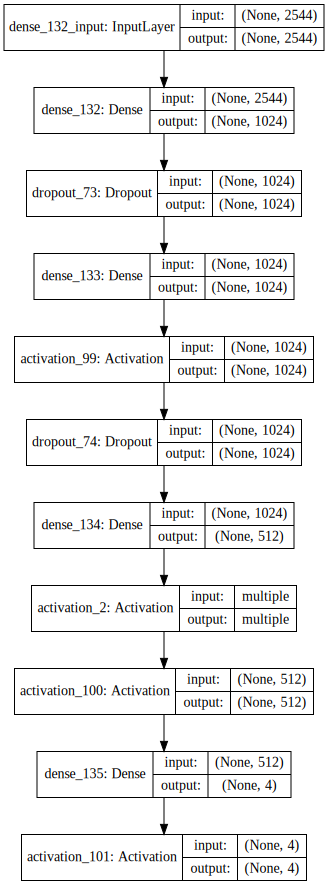

In [9]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(best_model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold


#----------------------------------------------------------
data = pd.read_csv('conventional_data_unique.csv', index_col='CID')
y_ = data['consensus_act']

X_all = data.drop(['consensus_act', 'gmin'], axis = 1)
X_all.replace([np.inf, -np.inf], np.nan, inplace=True) #replace all infinite values with NaN

X_all = X_all.dropna(axis=1, how='all') #Drop any column that has all NaN
X_all.fillna(value = X_all.mean(axis=0), inplace=True) #Impute mean in place on NaN

#X_all.loc[:, X_all.isnull().any()] See which column still had NaN after prepocessing. gmin was removed
print('Shape of X_all before removing low variance features:', X_all.shape)

#0.16 =(.8 * (1 - .8)) that is the threshold for features that are constant in 80% of the instances
feat = VarianceThreshold(threshold=0.16)
feat.fit_transform(X_all)
X_all = X_all[X_all.columns[feat.get_support(indices=True)]] #retain column names
print('Shape of X_all after removing low variance features:', X_all.shape)


#----------------------------------------------------------------------
n_splits=5
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=23)
cvscores=[]

# Model architecture to use for training, use the create_model function above
#_model = 


for fold, (train_idx, val_idx) in enumerate(kfold.split(X_all, y_)):
    print("Testing on fold " + str(fold+1) + " of " + str(n_splits))

    xtrain, xval = X_all.iloc[train_idx], X_all.iloc[val_idx]
    ytrain, yval = y_.values[train_idx], y_.values[val_idx]
    
    ytrain = pd.get_dummies(ytrain)
    yval = pd.get_dummies(yval)
    
    sc = StandardScaler().fit(xtrain)
    xtrain = pd.DataFrame(sc.transform(xtrain), columns = X_all.columns)
    xval = pd.DataFrame(sc.transform(xval), columns = X_all.columns)
    
    print(xtrain.shape, xval.shape, ytrain.shape, yval.shape)
    
    #Train model here or load saved model
    #_model = None
    #_model = 
    
    scores = _model.evaluate(xval, yval, verbose=0)
    print("%s: %.2f%%" % (_model.metrics_names[1], scores[1]))
    cvscores.append(scores[1])
    
    val_class = np.argmax(yval.values, axis=1)
    val_pred = _model.predict_classes(xval)
    #print(confusion_matrix(val_class, val_pred))
    
    
    #--------------------------------------------------------------------------
    #labels = ['active_agonist', 'active_antagonist', 'inactive', 'inconclusive']
    print(confusion_matrix(val_class, val_pred))
    print(classification_report(val_class, val_pred))
    print ("Precision:", metrics.precision_score(val_class, val_pred, average="macro"))
    print ("Recall:", metrics.recall_score(val_class, val_pred, average="macro"))
    print ("f1_score:", metrics.f1_score(val_class, val_pred, average="macro"))
    #------------------------------------------------
    y_proba = _model.predict_proba(xval)
    print('AUROC:', metrics.roc_auc_score(yval, y_proba, average="macro"))
    print('AUPRC:', metrics.average_precision_score(yval, y_proba, average="macro"))
    #-----------------------------------------------------------------------------
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))  
print(cvscores)

Shape of X_all before removing low variance features: (7665, 17967)
Shape of X_all after removing low variance features: (7665, 2544)
Testing on fold 1 of 5
(6130, 2544) (1535, 2544) (6130, 4) (1535, 4)
fmeasure: 0.91%
[[ 27   0   1   0]
 [  1  11   0   5]
 [  0   1 954  39]
 [  5   2  86 403]]
             precision    recall  f1-score   support

          0       0.82      0.96      0.89        28
          1       0.79      0.65      0.71        17
          2       0.92      0.96      0.94       994
          3       0.90      0.81      0.85       496

avg / total       0.91      0.91      0.91      1535

Precision: 0.855472153098
Recall: 0.845900772281
f1_score: 0.84680861014
AUROC: 0.968570135553
AUPRC: 0.889869280581
Testing on fold 2 of 5
(6131, 2544) (1534, 2544) (6131, 4) (1534, 4)
fmeasure: 0.91%
[[ 25   0   2   1]
 [  1  10   0   6]
 [  1   1 953  39]
 [  6   4  73 412]]
             precision    recall  f1-score   support

          0       0.76      0.89      0.82        

In [3]:
from keras.models import load_model
from talos.metrics.keras_metrics import fmeasure
_modelDL = load_model('conv_feat_unique_model_val.h5', custom_objects={'fmeasure': fmeasure})


from keras.utils import plot_model
plot_model(_modelDL, to_file='DL_model_architecture.svg')

In [4]:
import keras
keras.__version__

'2.1.4'

In [5]:
import tensorflow as tf
tf.VERSION

'1.9.0'

In [6]:
import sklearn
sklearn.__version__

'0.19.0'